## Poisson equation with variable coefficient
The Poisson equation on a unit disk with zero Dirichlet boundary condition can be written as $- \nabla \cdot (c\nabla  u) = 1$  in $\Omega$, $u=0$ on $\partial \Omega$ , where $\Omega$  is the unit disk. The exact solution when  is
$$
u(x,y)= \frac{1-x^2-y^2}{4}
$$


Here, objective is to compute the coefficient $c$ using PINN and we assume $c$ is scalar.

In [24]:
## Import the required modules
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

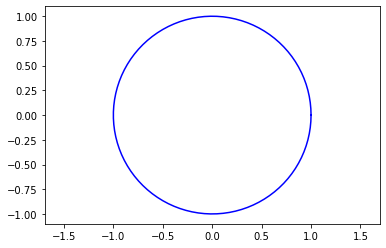

In [25]:
## Problem description
r = 1
theta = np.linspace(0, 2*np.pi, 100)
x = r*np.cos(theta)
y = r*np.sin(theta)
plt.plot(x, y, "-b", lw=1.5)
plt.axis("equal");

In [26]:
def generate_collocation_points(radius, num_samples):
    r = radius * np.sqrt(np.random.rand(num_samples, 1))
    theta = np.random.uniform(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)    
    xy = np.concatenate((x, y), axis=1)
    return xy

def generate_boundary_points(radius, num_samples):
    theta = np.linspace(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)
    xy = np.concatenate((x, y), axis=1)
    return xy

def analytical_sol(xy):
    u = (1/4.0)*(1 - xy[:, 0]*xy[:,0] - xy[:, 1]* xy[:, 1])
    u = u.reshape(-1, 1)
    return u


def generate_validation_data(radius, num_samples):
    r = radius * np.sqrt(np.random.rand(num_samples, 1))
    theta = np.random.uniform(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)
    xy = np.concatentae((x, y), axis=1)
    return xy
    



In [45]:
class PINN(nn.Module):
    def __init__(self, input_size, num_neurons, output_size):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.activation_1 = nn.Tanh()
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.activation_2 = nn.Tanh()
        self.fc3 = nn.Linear(num_neurons, output_size)
    

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_1(x)
        x = self.fc2(x)
        x = self.activation_2(x)
        x = self.fc3(x)
        return x
    
    

def net_f(model, model_c, xy_f):    
    u = model(xy_f)
    c = model_c(xy_f)    
    grad_u = torch.autograd.grad(u, xy_f, grad_outputs=torch.ones_like(u),
                                 create_graph=True)[0]
    c = c.squeeze()
    u_xx = torch.autograd.grad(c*grad_u[:, 0], xy_f, grad_outputs=torch.ones_like(grad_u[:, 0]),
                               create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(c*grad_u[:, 1], xy_f, grad_outputs=torch.ones_like(grad_u[:, 1]),
                               create_graph=True)[0][:, 1]
    return u_xx + u_yy + 1.0

def net_d(model, x_d):
    u = model(x_d)
    return u

def loss_fn(model, model_c, xy_f, xy_d, u_d):
    f = net_f(model,model_c,xy_f)
    d = net_d(model, xy_d)
    loss_f = (f**2).mean() 
    loss_d = ((d - u_d)**2).mean()
    loss = loss_d + 0.01*loss_f
    return loss

    
    

In [52]:
if __name__=="__main__":
    r =1.0
    num_collocation_points = 1000
    num_boundary_points = 100
    num_data = 200
    
    # Initialize Collocation Points
    xy_f = torch.tensor(generate_collocation_points(r, num_collocation_points), requires_grad=True, 
                        dtype=torch.float32)
  
    
    # Initialize boundary points
    xy_b = torch.tensor(generate_boundary_points(r, num_boundary_points), dtype=torch.float32)
    u_b = torch.zeros((xy_b.size(0), 1), dtype=torch.float32)
    
    # Initialize data values
    xy_d = generate_collocation_points(r, num_data)
    u_d = analytical_sol(xy_d)
    xy_d = torch.tensor(xy_d, dtype=torch.float32)
    u_d = torch.tensor(u_d, dtype=torch.float32)
 
    # Concatenate boundary and interior data points
    xy_data = torch.concatenate((xy_b, xy_d), axis=0)
    u_data = torch.concatenate((u_b, u_d), axis=0)
    nIters = 15000
    d_in = 2
    num_neurons = 60
    d_out = 1
    lr = 1e-03
    model = PINN(d_in, num_neurons, d_out)
    model_c = PINN(d_in, num_neurons, d_out)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(model_c.parameters()), lr = lr)
    loss_history = []
    c_history = np.zeros(shape=(nIters, 1))
        
    # Start Training    
    for it in range(0, nIters):
        optimizer.zero_grad()
        loss = loss_fn(model, model_c, xy_f, xy_d, u_d)
        loss.backward()
        optimizer.step()
        if it % 1 == 0:
            #c = model.get_parameter().detach().cpu().numpy()
            print(f"Epoch {it+1}/{nIters}, Loss: {loss:.8f}") 
            #c_history[it]= c
            #print(f"Type: {type(c)}")
            loss_history.append(loss.detach().cpu().numpy())

      


Epoch 1/15000, Loss: 0.02992878
Epoch 2/15000, Loss: 0.02163447
Epoch 3/15000, Loss: 0.01825917
Epoch 4/15000, Loss: 0.01555742
Epoch 5/15000, Loss: 0.01457212
Epoch 6/15000, Loss: 0.01544274
Epoch 7/15000, Loss: 0.01633149
Epoch 8/15000, Loss: 0.01641402
Epoch 9/15000, Loss: 0.01622511
Epoch 10/15000, Loss: 0.01607368
Epoch 11/15000, Loss: 0.01569379
Epoch 12/15000, Loss: 0.01496641
Epoch 13/15000, Loss: 0.01420446
Epoch 14/15000, Loss: 0.01372084
Epoch 15/15000, Loss: 0.01347513
Epoch 16/15000, Loss: 0.01323271
Epoch 17/15000, Loss: 0.01292745
Epoch 18/15000, Loss: 0.01268240
Epoch 19/15000, Loss: 0.01255793
Epoch 20/15000, Loss: 0.01244232
Epoch 21/15000, Loss: 0.01221301
Epoch 22/15000, Loss: 0.01189157
Epoch 23/15000, Loss: 0.01157065
Epoch 24/15000, Loss: 0.01126087
Epoch 25/15000, Loss: 0.01089087
Epoch 26/15000, Loss: 0.01043721
Epoch 27/15000, Loss: 0.00996923
Epoch 28/15000, Loss: 0.00955316
Epoch 29/15000, Loss: 0.00917585
Epoch 30/15000, Loss: 0.00879436
Epoch 31/15000, Los

Epoch 253/15000, Loss: 0.00045835
Epoch 254/15000, Loss: 0.00045147
Epoch 255/15000, Loss: 0.00044463
Epoch 256/15000, Loss: 0.00043783
Epoch 257/15000, Loss: 0.00043107
Epoch 258/15000, Loss: 0.00042436
Epoch 259/15000, Loss: 0.00041769
Epoch 260/15000, Loss: 0.00041107
Epoch 261/15000, Loss: 0.00040449
Epoch 262/15000, Loss: 0.00039795
Epoch 263/15000, Loss: 0.00039146
Epoch 264/15000, Loss: 0.00038501
Epoch 265/15000, Loss: 0.00037860
Epoch 266/15000, Loss: 0.00037224
Epoch 267/15000, Loss: 0.00036593
Epoch 268/15000, Loss: 0.00035966
Epoch 269/15000, Loss: 0.00035343
Epoch 270/15000, Loss: 0.00034725
Epoch 271/15000, Loss: 0.00034112
Epoch 272/15000, Loss: 0.00033504
Epoch 273/15000, Loss: 0.00032900
Epoch 274/15000, Loss: 0.00032301
Epoch 275/15000, Loss: 0.00031707
Epoch 276/15000, Loss: 0.00031117
Epoch 277/15000, Loss: 0.00030533
Epoch 278/15000, Loss: 0.00029953
Epoch 279/15000, Loss: 0.00029378
Epoch 280/15000, Loss: 0.00028809
Epoch 281/15000, Loss: 0.00028244
Epoch 282/1500

Epoch 506/15000, Loss: 0.00002178
Epoch 507/15000, Loss: 0.00003907
Epoch 508/15000, Loss: 0.00004996
Epoch 509/15000, Loss: 0.00003542
Epoch 510/15000, Loss: 0.00002144
Epoch 511/15000, Loss: 0.00002853
Epoch 512/15000, Loss: 0.00003936
Epoch 513/15000, Loss: 0.00003399
Epoch 514/15000, Loss: 0.00002260
Epoch 515/15000, Loss: 0.00002331
Epoch 516/15000, Loss: 0.00003147
Epoch 517/15000, Loss: 0.00003147
Epoch 518/15000, Loss: 0.00002382
Epoch 519/15000, Loss: 0.00002122
Epoch 520/15000, Loss: 0.00002600
Epoch 521/15000, Loss: 0.00002850
Epoch 522/15000, Loss: 0.00002455
Epoch 523/15000, Loss: 0.00002091
Epoch 524/15000, Loss: 0.00002261
Epoch 525/15000, Loss: 0.00002553
Epoch 526/15000, Loss: 0.00002452
Epoch 527/15000, Loss: 0.00002144
Epoch 528/15000, Loss: 0.00002096
Epoch 529/15000, Loss: 0.00002297
Epoch 530/15000, Loss: 0.00002370
Epoch 531/15000, Loss: 0.00002203
Epoch 532/15000, Loss: 0.00002061
Epoch 533/15000, Loss: 0.00002123
Epoch 534/15000, Loss: 0.00002240
Epoch 535/1500

Epoch 756/15000, Loss: 0.00001627
Epoch 757/15000, Loss: 0.00001626
Epoch 758/15000, Loss: 0.00001626
Epoch 759/15000, Loss: 0.00001625
Epoch 760/15000, Loss: 0.00001623
Epoch 761/15000, Loss: 0.00001621
Epoch 762/15000, Loss: 0.00001618
Epoch 763/15000, Loss: 0.00001617
Epoch 764/15000, Loss: 0.00001616
Epoch 765/15000, Loss: 0.00001615
Epoch 766/15000, Loss: 0.00001614
Epoch 767/15000, Loss: 0.00001612
Epoch 768/15000, Loss: 0.00001610
Epoch 769/15000, Loss: 0.00001608
Epoch 770/15000, Loss: 0.00001607
Epoch 771/15000, Loss: 0.00001606
Epoch 772/15000, Loss: 0.00001605
Epoch 773/15000, Loss: 0.00001603
Epoch 774/15000, Loss: 0.00001602
Epoch 775/15000, Loss: 0.00001600
Epoch 776/15000, Loss: 0.00001598
Epoch 777/15000, Loss: 0.00001597
Epoch 778/15000, Loss: 0.00001596
Epoch 779/15000, Loss: 0.00001594
Epoch 780/15000, Loss: 0.00001593
Epoch 781/15000, Loss: 0.00001592
Epoch 782/15000, Loss: 0.00001590
Epoch 783/15000, Loss: 0.00001589
Epoch 784/15000, Loss: 0.00001587
Epoch 785/1500

Epoch 1003/15000, Loss: 0.00001351
Epoch 1004/15000, Loss: 0.00001350
Epoch 1005/15000, Loss: 0.00001349
Epoch 1006/15000, Loss: 0.00001348
Epoch 1007/15000, Loss: 0.00001347
Epoch 1008/15000, Loss: 0.00001346
Epoch 1009/15000, Loss: 0.00001345
Epoch 1010/15000, Loss: 0.00001344
Epoch 1011/15000, Loss: 0.00001343
Epoch 1012/15000, Loss: 0.00001342
Epoch 1013/15000, Loss: 0.00001341
Epoch 1014/15000, Loss: 0.00001340
Epoch 1015/15000, Loss: 0.00001339
Epoch 1016/15000, Loss: 0.00001338
Epoch 1017/15000, Loss: 0.00001337
Epoch 1018/15000, Loss: 0.00001336
Epoch 1019/15000, Loss: 0.00001335
Epoch 1020/15000, Loss: 0.00001334
Epoch 1021/15000, Loss: 0.00001333
Epoch 1022/15000, Loss: 0.00001332
Epoch 1023/15000, Loss: 0.00001331
Epoch 1024/15000, Loss: 0.00001331
Epoch 1025/15000, Loss: 0.00001330
Epoch 1026/15000, Loss: 0.00001329
Epoch 1027/15000, Loss: 0.00001328
Epoch 1028/15000, Loss: 0.00001327
Epoch 1029/15000, Loss: 0.00001326
Epoch 1030/15000, Loss: 0.00001325
Epoch 1031/15000, Lo

Epoch 1241/15000, Loss: 0.00001165
Epoch 1242/15000, Loss: 0.00001165
Epoch 1243/15000, Loss: 0.00001164
Epoch 1244/15000, Loss: 0.00001163
Epoch 1245/15000, Loss: 0.00001162
Epoch 1246/15000, Loss: 0.00001162
Epoch 1247/15000, Loss: 0.00001161
Epoch 1248/15000, Loss: 0.00001160
Epoch 1249/15000, Loss: 0.00001159
Epoch 1250/15000, Loss: 0.00001159
Epoch 1251/15000, Loss: 0.00001158
Epoch 1252/15000, Loss: 0.00001157
Epoch 1253/15000, Loss: 0.00001156
Epoch 1254/15000, Loss: 0.00001156
Epoch 1255/15000, Loss: 0.00001155
Epoch 1256/15000, Loss: 0.00001154
Epoch 1257/15000, Loss: 0.00001153
Epoch 1258/15000, Loss: 0.00001153
Epoch 1259/15000, Loss: 0.00001152
Epoch 1260/15000, Loss: 0.00001151
Epoch 1261/15000, Loss: 0.00001150
Epoch 1262/15000, Loss: 0.00001150
Epoch 1263/15000, Loss: 0.00001149
Epoch 1264/15000, Loss: 0.00001148
Epoch 1265/15000, Loss: 0.00001148
Epoch 1266/15000, Loss: 0.00001147
Epoch 1267/15000, Loss: 0.00001146
Epoch 1268/15000, Loss: 0.00001145
Epoch 1269/15000, Lo

Epoch 1483/15000, Loss: 0.00001021
Epoch 1484/15000, Loss: 0.00001021
Epoch 1485/15000, Loss: 0.00001020
Epoch 1486/15000, Loss: 0.00001020
Epoch 1487/15000, Loss: 0.00001019
Epoch 1488/15000, Loss: 0.00001018
Epoch 1489/15000, Loss: 0.00001018
Epoch 1490/15000, Loss: 0.00001017
Epoch 1491/15000, Loss: 0.00001017
Epoch 1492/15000, Loss: 0.00001016
Epoch 1493/15000, Loss: 0.00001015
Epoch 1494/15000, Loss: 0.00001015
Epoch 1495/15000, Loss: 0.00001014
Epoch 1496/15000, Loss: 0.00001014
Epoch 1497/15000, Loss: 0.00001013
Epoch 1498/15000, Loss: 0.00001012
Epoch 1499/15000, Loss: 0.00001012
Epoch 1500/15000, Loss: 0.00001011
Epoch 1501/15000, Loss: 0.00001011
Epoch 1502/15000, Loss: 0.00001010
Epoch 1503/15000, Loss: 0.00001009
Epoch 1504/15000, Loss: 0.00001009
Epoch 1505/15000, Loss: 0.00001008
Epoch 1506/15000, Loss: 0.00001008
Epoch 1507/15000, Loss: 0.00001007
Epoch 1508/15000, Loss: 0.00001006
Epoch 1509/15000, Loss: 0.00001006
Epoch 1510/15000, Loss: 0.00001005
Epoch 1511/15000, Lo

Epoch 1718/15000, Loss: 0.00000912
Epoch 1719/15000, Loss: 0.00000911
Epoch 1720/15000, Loss: 0.00000909
Epoch 1721/15000, Loss: 0.00000908
Epoch 1722/15000, Loss: 0.00000909
Epoch 1723/15000, Loss: 0.00000909
Epoch 1724/15000, Loss: 0.00000908
Epoch 1725/15000, Loss: 0.00000907
Epoch 1726/15000, Loss: 0.00000906
Epoch 1727/15000, Loss: 0.00000906
Epoch 1728/15000, Loss: 0.00000906
Epoch 1729/15000, Loss: 0.00000905
Epoch 1730/15000, Loss: 0.00000904
Epoch 1731/15000, Loss: 0.00000903
Epoch 1732/15000, Loss: 0.00000903
Epoch 1733/15000, Loss: 0.00000903
Epoch 1734/15000, Loss: 0.00000902
Epoch 1735/15000, Loss: 0.00000901
Epoch 1736/15000, Loss: 0.00000901
Epoch 1737/15000, Loss: 0.00000900
Epoch 1738/15000, Loss: 0.00000900
Epoch 1739/15000, Loss: 0.00000900
Epoch 1740/15000, Loss: 0.00000899
Epoch 1741/15000, Loss: 0.00000898
Epoch 1742/15000, Loss: 0.00000898
Epoch 1743/15000, Loss: 0.00000897
Epoch 1744/15000, Loss: 0.00000897
Epoch 1745/15000, Loss: 0.00000896
Epoch 1746/15000, Lo

Epoch 1957/15000, Loss: 0.00004349
Epoch 1958/15000, Loss: 0.00001076
Epoch 1959/15000, Loss: 0.00006355
Epoch 1960/15000, Loss: 0.00008138
Epoch 1961/15000, Loss: 0.00003040
Epoch 1962/15000, Loss: 0.00001042
Epoch 1963/15000, Loss: 0.00004620
Epoch 1964/15000, Loss: 0.00005502
Epoch 1965/15000, Loss: 0.00002040
Epoch 1966/15000, Loss: 0.00001071
Epoch 1967/15000, Loss: 0.00003526
Epoch 1968/15000, Loss: 0.00003772
Epoch 1969/15000, Loss: 0.00001425
Epoch 1970/15000, Loss: 0.00001097
Epoch 1971/15000, Loss: 0.00002752
Epoch 1972/15000, Loss: 0.00002648
Epoch 1973/15000, Loss: 0.00001092
Epoch 1974/15000, Loss: 0.00001095
Epoch 1975/15000, Loss: 0.00002177
Epoch 1976/15000, Loss: 0.00001936
Epoch 1977/15000, Loss: 0.00000930
Epoch 1978/15000, Loss: 0.00001065
Epoch 1979/15000, Loss: 0.00001755
Epoch 1980/15000, Loss: 0.00001496
Epoch 1981/15000, Loss: 0.00000858
Epoch 1982/15000, Loss: 0.00001018
Epoch 1983/15000, Loss: 0.00001451
Epoch 1984/15000, Loss: 0.00001230
Epoch 1985/15000, Lo

Epoch 2202/15000, Loss: 0.00000725
Epoch 2203/15000, Loss: 0.00000725
Epoch 2204/15000, Loss: 0.00000724
Epoch 2205/15000, Loss: 0.00000724
Epoch 2206/15000, Loss: 0.00000723
Epoch 2207/15000, Loss: 0.00000723
Epoch 2208/15000, Loss: 0.00000723
Epoch 2209/15000, Loss: 0.00000722
Epoch 2210/15000, Loss: 0.00000722
Epoch 2211/15000, Loss: 0.00000722
Epoch 2212/15000, Loss: 0.00000721
Epoch 2213/15000, Loss: 0.00000721
Epoch 2214/15000, Loss: 0.00000721
Epoch 2215/15000, Loss: 0.00000720
Epoch 2216/15000, Loss: 0.00000720
Epoch 2217/15000, Loss: 0.00000720
Epoch 2218/15000, Loss: 0.00000719
Epoch 2219/15000, Loss: 0.00000719
Epoch 2220/15000, Loss: 0.00000719
Epoch 2221/15000, Loss: 0.00000718
Epoch 2222/15000, Loss: 0.00000718
Epoch 2223/15000, Loss: 0.00000718
Epoch 2224/15000, Loss: 0.00000717
Epoch 2225/15000, Loss: 0.00000717
Epoch 2226/15000, Loss: 0.00000717
Epoch 2227/15000, Loss: 0.00000716
Epoch 2228/15000, Loss: 0.00000716
Epoch 2229/15000, Loss: 0.00000715
Epoch 2230/15000, Lo

Epoch 2444/15000, Loss: 0.00000664
Epoch 2445/15000, Loss: 0.00000663
Epoch 2446/15000, Loss: 0.00000663
Epoch 2447/15000, Loss: 0.00000663
Epoch 2448/15000, Loss: 0.00000662
Epoch 2449/15000, Loss: 0.00000662
Epoch 2450/15000, Loss: 0.00000662
Epoch 2451/15000, Loss: 0.00000662
Epoch 2452/15000, Loss: 0.00000661
Epoch 2453/15000, Loss: 0.00000661
Epoch 2454/15000, Loss: 0.00000661
Epoch 2455/15000, Loss: 0.00000660
Epoch 2456/15000, Loss: 0.00000660
Epoch 2457/15000, Loss: 0.00000660
Epoch 2458/15000, Loss: 0.00000660
Epoch 2459/15000, Loss: 0.00000659
Epoch 2460/15000, Loss: 0.00000659
Epoch 2461/15000, Loss: 0.00000659
Epoch 2462/15000, Loss: 0.00000658
Epoch 2463/15000, Loss: 0.00000658
Epoch 2464/15000, Loss: 0.00000658
Epoch 2465/15000, Loss: 0.00000657
Epoch 2466/15000, Loss: 0.00000657
Epoch 2467/15000, Loss: 0.00000657
Epoch 2468/15000, Loss: 0.00000657
Epoch 2469/15000, Loss: 0.00000656
Epoch 2470/15000, Loss: 0.00000656
Epoch 2471/15000, Loss: 0.00000656
Epoch 2472/15000, Lo

Epoch 2689/15000, Loss: 0.00000743
Epoch 2690/15000, Loss: 0.00000960
Epoch 2691/15000, Loss: 0.00001922
Epoch 2692/15000, Loss: 0.00001767
Epoch 2693/15000, Loss: 0.00000840
Epoch 2694/15000, Loss: 0.00000702
Epoch 2695/15000, Loss: 0.00001332
Epoch 2696/15000, Loss: 0.00001463
Epoch 2697/15000, Loss: 0.00000895
Epoch 2698/15000, Loss: 0.00000617
Epoch 2699/15000, Loss: 0.00000963
Epoch 2700/15000, Loss: 0.00001194
Epoch 2701/15000, Loss: 0.00000905
Epoch 2702/15000, Loss: 0.00000616
Epoch 2703/15000, Loss: 0.00000752
Epoch 2704/15000, Loss: 0.00000976
Epoch 2705/15000, Loss: 0.00000877
Epoch 2706/15000, Loss: 0.00000644
Epoch 2707/15000, Loss: 0.00000648
Epoch 2708/15000, Loss: 0.00000812
Epoch 2709/15000, Loss: 0.00000824
Epoch 2710/15000, Loss: 0.00000673
Epoch 2711/15000, Loss: 0.00000611
Epoch 2712/15000, Loss: 0.00000702
Epoch 2713/15000, Loss: 0.00000760
Epoch 2714/15000, Loss: 0.00000686
Epoch 2715/15000, Loss: 0.00000609
Epoch 2716/15000, Loss: 0.00000639
Epoch 2717/15000, Lo

Epoch 2929/15000, Loss: 0.00000558
Epoch 2930/15000, Loss: 0.00000558
Epoch 2931/15000, Loss: 0.00000558
Epoch 2932/15000, Loss: 0.00000558
Epoch 2933/15000, Loss: 0.00000557
Epoch 2934/15000, Loss: 0.00000557
Epoch 2935/15000, Loss: 0.00000557
Epoch 2936/15000, Loss: 0.00000557
Epoch 2937/15000, Loss: 0.00000557
Epoch 2938/15000, Loss: 0.00000556
Epoch 2939/15000, Loss: 0.00000556
Epoch 2940/15000, Loss: 0.00000556
Epoch 2941/15000, Loss: 0.00000556
Epoch 2942/15000, Loss: 0.00000556
Epoch 2943/15000, Loss: 0.00000555
Epoch 2944/15000, Loss: 0.00000555
Epoch 2945/15000, Loss: 0.00000555
Epoch 2946/15000, Loss: 0.00000555
Epoch 2947/15000, Loss: 0.00000555
Epoch 2948/15000, Loss: 0.00000554
Epoch 2949/15000, Loss: 0.00000554
Epoch 2950/15000, Loss: 0.00000554
Epoch 2951/15000, Loss: 0.00000554
Epoch 2952/15000, Loss: 0.00000553
Epoch 2953/15000, Loss: 0.00000553
Epoch 2954/15000, Loss: 0.00000553
Epoch 2955/15000, Loss: 0.00000553
Epoch 2956/15000, Loss: 0.00000553
Epoch 2957/15000, Lo

Epoch 3174/15000, Loss: 0.00000522
Epoch 3175/15000, Loss: 0.00000522
Epoch 3176/15000, Loss: 0.00000521
Epoch 3177/15000, Loss: 0.00000521
Epoch 3178/15000, Loss: 0.00000521
Epoch 3179/15000, Loss: 0.00000521
Epoch 3180/15000, Loss: 0.00000521
Epoch 3181/15000, Loss: 0.00000521
Epoch 3182/15000, Loss: 0.00000520
Epoch 3183/15000, Loss: 0.00000520
Epoch 3184/15000, Loss: 0.00000520
Epoch 3185/15000, Loss: 0.00000520
Epoch 3186/15000, Loss: 0.00000520
Epoch 3187/15000, Loss: 0.00000519
Epoch 3188/15000, Loss: 0.00000519
Epoch 3189/15000, Loss: 0.00000519
Epoch 3190/15000, Loss: 0.00000519
Epoch 3191/15000, Loss: 0.00000519
Epoch 3192/15000, Loss: 0.00000519
Epoch 3193/15000, Loss: 0.00000518
Epoch 3194/15000, Loss: 0.00000518
Epoch 3195/15000, Loss: 0.00000518
Epoch 3196/15000, Loss: 0.00000518
Epoch 3197/15000, Loss: 0.00000518
Epoch 3198/15000, Loss: 0.00000517
Epoch 3199/15000, Loss: 0.00000517
Epoch 3200/15000, Loss: 0.00000517
Epoch 3201/15000, Loss: 0.00000517
Epoch 3202/15000, Lo

Epoch 3414/15000, Loss: 0.00000495
Epoch 3415/15000, Loss: 0.00000498
Epoch 3416/15000, Loss: 0.00000495
Epoch 3417/15000, Loss: 0.00000491
Epoch 3418/15000, Loss: 0.00000490
Epoch 3419/15000, Loss: 0.00000492
Epoch 3420/15000, Loss: 0.00000494
Epoch 3421/15000, Loss: 0.00000492
Epoch 3422/15000, Loss: 0.00000489
Epoch 3423/15000, Loss: 0.00000489
Epoch 3424/15000, Loss: 0.00000490
Epoch 3425/15000, Loss: 0.00000491
Epoch 3426/15000, Loss: 0.00000490
Epoch 3427/15000, Loss: 0.00000488
Epoch 3428/15000, Loss: 0.00000488
Epoch 3429/15000, Loss: 0.00000488
Epoch 3430/15000, Loss: 0.00000489
Epoch 3431/15000, Loss: 0.00000489
Epoch 3432/15000, Loss: 0.00000487
Epoch 3433/15000, Loss: 0.00000487
Epoch 3434/15000, Loss: 0.00000487
Epoch 3435/15000, Loss: 0.00000487
Epoch 3436/15000, Loss: 0.00000487
Epoch 3437/15000, Loss: 0.00000487
Epoch 3438/15000, Loss: 0.00000486
Epoch 3439/15000, Loss: 0.00000486
Epoch 3440/15000, Loss: 0.00000486
Epoch 3441/15000, Loss: 0.00000486
Epoch 3442/15000, Lo

Epoch 3657/15000, Loss: 0.00000459
Epoch 3658/15000, Loss: 0.00000463
Epoch 3659/15000, Loss: 0.00000471
Epoch 3660/15000, Loss: 0.00000487
Epoch 3661/15000, Loss: 0.00000514
Epoch 3662/15000, Loss: 0.00000566
Epoch 3663/15000, Loss: 0.00000660
Epoch 3664/15000, Loss: 0.00000835
Epoch 3665/15000, Loss: 0.00001161
Epoch 3666/15000, Loss: 0.00001768
Epoch 3667/15000, Loss: 0.00002900
Epoch 3668/15000, Loss: 0.00004995
Epoch 3669/15000, Loss: 0.00008811
Epoch 3670/15000, Loss: 0.00015495
Epoch 3671/15000, Loss: 0.00026366
Epoch 3672/15000, Loss: 0.00041426
Epoch 3673/15000, Loss: 0.00056219
Epoch 3674/15000, Loss: 0.00059163
Epoch 3675/15000, Loss: 0.00041001
Epoch 3676/15000, Loss: 0.00012710
Epoch 3677/15000, Loss: 0.00000487
Epoch 3678/15000, Loss: 0.00011999
Epoch 3679/15000, Loss: 0.00026842
Epoch 3680/15000, Loss: 0.00023390
Epoch 3681/15000, Loss: 0.00006874
Epoch 3682/15000, Loss: 0.00000819
Epoch 3683/15000, Loss: 0.00010245
Epoch 3684/15000, Loss: 0.00016482
Epoch 3685/15000, Lo

Epoch 3896/15000, Loss: 0.00000433
Epoch 3897/15000, Loss: 0.00000433
Epoch 3898/15000, Loss: 0.00000433
Epoch 3899/15000, Loss: 0.00000433
Epoch 3900/15000, Loss: 0.00000433
Epoch 3901/15000, Loss: 0.00000433
Epoch 3902/15000, Loss: 0.00000432
Epoch 3903/15000, Loss: 0.00000432
Epoch 3904/15000, Loss: 0.00000432
Epoch 3905/15000, Loss: 0.00000432
Epoch 3906/15000, Loss: 0.00000432
Epoch 3907/15000, Loss: 0.00000432
Epoch 3908/15000, Loss: 0.00000432
Epoch 3909/15000, Loss: 0.00000432
Epoch 3910/15000, Loss: 0.00000432
Epoch 3911/15000, Loss: 0.00000431
Epoch 3912/15000, Loss: 0.00000431
Epoch 3913/15000, Loss: 0.00000431
Epoch 3914/15000, Loss: 0.00000431
Epoch 3915/15000, Loss: 0.00000431
Epoch 3916/15000, Loss: 0.00000431
Epoch 3917/15000, Loss: 0.00000431
Epoch 3918/15000, Loss: 0.00000431
Epoch 3919/15000, Loss: 0.00000431
Epoch 3920/15000, Loss: 0.00000430
Epoch 3921/15000, Loss: 0.00000430
Epoch 3922/15000, Loss: 0.00000430
Epoch 3923/15000, Loss: 0.00000430
Epoch 3924/15000, Lo

Epoch 4142/15000, Loss: 0.00000433
Epoch 4143/15000, Loss: 0.00000426
Epoch 4144/15000, Loss: 0.00000416
Epoch 4145/15000, Loss: 0.00000415
Epoch 4146/15000, Loss: 0.00000422
Epoch 4147/15000, Loss: 0.00000425
Epoch 4148/15000, Loss: 0.00000420
Epoch 4149/15000, Loss: 0.00000415
Epoch 4150/15000, Loss: 0.00000415
Epoch 4151/15000, Loss: 0.00000419
Epoch 4152/15000, Loss: 0.00000420
Epoch 4153/15000, Loss: 0.00000417
Epoch 4154/15000, Loss: 0.00000414
Epoch 4155/15000, Loss: 0.00000414
Epoch 4156/15000, Loss: 0.00000416
Epoch 4157/15000, Loss: 0.00000417
Epoch 4158/15000, Loss: 0.00000415
Epoch 4159/15000, Loss: 0.00000413
Epoch 4160/15000, Loss: 0.00000413
Epoch 4161/15000, Loss: 0.00000414
Epoch 4162/15000, Loss: 0.00000415
Epoch 4163/15000, Loss: 0.00000414
Epoch 4164/15000, Loss: 0.00000413
Epoch 4165/15000, Loss: 0.00000412
Epoch 4166/15000, Loss: 0.00000413
Epoch 4167/15000, Loss: 0.00000413
Epoch 4168/15000, Loss: 0.00000413
Epoch 4169/15000, Loss: 0.00000412
Epoch 4170/15000, Lo

Epoch 4385/15000, Loss: 0.00000391
Epoch 4386/15000, Loss: 0.00000391
Epoch 4387/15000, Loss: 0.00000391
Epoch 4388/15000, Loss: 0.00000391
Epoch 4389/15000, Loss: 0.00000391
Epoch 4390/15000, Loss: 0.00000392
Epoch 4391/15000, Loss: 0.00000393
Epoch 4392/15000, Loss: 0.00000395
Epoch 4393/15000, Loss: 0.00000398
Epoch 4394/15000, Loss: 0.00000403
Epoch 4395/15000, Loss: 0.00000412
Epoch 4396/15000, Loss: 0.00000429
Epoch 4397/15000, Loss: 0.00000459
Epoch 4398/15000, Loss: 0.00000512
Epoch 4399/15000, Loss: 0.00000609
Epoch 4400/15000, Loss: 0.00000783
Epoch 4401/15000, Loss: 0.00001099
Epoch 4402/15000, Loss: 0.00001674
Epoch 4403/15000, Loss: 0.00002720
Epoch 4404/15000, Loss: 0.00004605
Epoch 4405/15000, Loss: 0.00007951
Epoch 4406/15000, Loss: 0.00013661
Epoch 4407/15000, Loss: 0.00022734
Epoch 4408/15000, Loss: 0.00035115
Epoch 4409/15000, Loss: 0.00047431
Epoch 4410/15000, Loss: 0.00050902
Epoch 4411/15000, Loss: 0.00037707
Epoch 4412/15000, Loss: 0.00014223
Epoch 4413/15000, Lo

Epoch 4631/15000, Loss: 0.00000377
Epoch 4632/15000, Loss: 0.00000377
Epoch 4633/15000, Loss: 0.00000377
Epoch 4634/15000, Loss: 0.00000377
Epoch 4635/15000, Loss: 0.00000377
Epoch 4636/15000, Loss: 0.00000376
Epoch 4637/15000, Loss: 0.00000376
Epoch 4638/15000, Loss: 0.00000376
Epoch 4639/15000, Loss: 0.00000376
Epoch 4640/15000, Loss: 0.00000376
Epoch 4641/15000, Loss: 0.00000376
Epoch 4642/15000, Loss: 0.00000376
Epoch 4643/15000, Loss: 0.00000376
Epoch 4644/15000, Loss: 0.00000376
Epoch 4645/15000, Loss: 0.00000376
Epoch 4646/15000, Loss: 0.00000376
Epoch 4647/15000, Loss: 0.00000375
Epoch 4648/15000, Loss: 0.00000375
Epoch 4649/15000, Loss: 0.00000375
Epoch 4650/15000, Loss: 0.00000375
Epoch 4651/15000, Loss: 0.00000375
Epoch 4652/15000, Loss: 0.00000375
Epoch 4653/15000, Loss: 0.00000375
Epoch 4654/15000, Loss: 0.00000375
Epoch 4655/15000, Loss: 0.00000375
Epoch 4656/15000, Loss: 0.00000375
Epoch 4657/15000, Loss: 0.00000375
Epoch 4658/15000, Loss: 0.00000375
Epoch 4659/15000, Lo

Epoch 4870/15000, Loss: 0.00000370
Epoch 4871/15000, Loss: 0.00000366
Epoch 4872/15000, Loss: 0.00000363
Epoch 4873/15000, Loss: 0.00000364
Epoch 4874/15000, Loss: 0.00000366
Epoch 4875/15000, Loss: 0.00000366
Epoch 4876/15000, Loss: 0.00000364
Epoch 4877/15000, Loss: 0.00000362
Epoch 4878/15000, Loss: 0.00000363
Epoch 4879/15000, Loss: 0.00000364
Epoch 4880/15000, Loss: 0.00000364
Epoch 4881/15000, Loss: 0.00000363
Epoch 4882/15000, Loss: 0.00000362
Epoch 4883/15000, Loss: 0.00000362
Epoch 4884/15000, Loss: 0.00000363
Epoch 4885/15000, Loss: 0.00000363
Epoch 4886/15000, Loss: 0.00000362
Epoch 4887/15000, Loss: 0.00000362
Epoch 4888/15000, Loss: 0.00000362
Epoch 4889/15000, Loss: 0.00000362
Epoch 4890/15000, Loss: 0.00000362
Epoch 4891/15000, Loss: 0.00000362
Epoch 4892/15000, Loss: 0.00000361
Epoch 4893/15000, Loss: 0.00000361
Epoch 4894/15000, Loss: 0.00000361
Epoch 4895/15000, Loss: 0.00000361
Epoch 4896/15000, Loss: 0.00000361
Epoch 4897/15000, Loss: 0.00000361
Epoch 4898/15000, Lo

Epoch 5107/15000, Loss: 0.00000344
Epoch 5108/15000, Loss: 0.00000344
Epoch 5109/15000, Loss: 0.00000345
Epoch 5110/15000, Loss: 0.00000347
Epoch 5111/15000, Loss: 0.00000350
Epoch 5112/15000, Loss: 0.00000354
Epoch 5113/15000, Loss: 0.00000362
Epoch 5114/15000, Loss: 0.00000375
Epoch 5115/15000, Loss: 0.00000398
Epoch 5116/15000, Loss: 0.00000437
Epoch 5117/15000, Loss: 0.00000505
Epoch 5118/15000, Loss: 0.00000622
Epoch 5119/15000, Loss: 0.00000827
Epoch 5120/15000, Loss: 0.00001186
Epoch 5121/15000, Loss: 0.00001814
Epoch 5122/15000, Loss: 0.00002914
Epoch 5123/15000, Loss: 0.00004814
Epoch 5124/15000, Loss: 0.00008034
Epoch 5125/15000, Loss: 0.00013240
Epoch 5126/15000, Loss: 0.00020998
Epoch 5127/15000, Loss: 0.00030731
Epoch 5128/15000, Loss: 0.00039243
Epoch 5129/15000, Loss: 0.00039956
Epoch 5130/15000, Loss: 0.00028495
Epoch 5131/15000, Loss: 0.00010685
Epoch 5132/15000, Loss: 0.00000596
Epoch 5133/15000, Loss: 0.00004717
Epoch 5134/15000, Loss: 0.00014839
Epoch 5135/15000, Lo

Epoch 5351/15000, Loss: 0.00000329
Epoch 5352/15000, Loss: 0.00000329
Epoch 5353/15000, Loss: 0.00000329
Epoch 5354/15000, Loss: 0.00000329
Epoch 5355/15000, Loss: 0.00000329
Epoch 5356/15000, Loss: 0.00000329
Epoch 5357/15000, Loss: 0.00000329
Epoch 5358/15000, Loss: 0.00000329
Epoch 5359/15000, Loss: 0.00000329
Epoch 5360/15000, Loss: 0.00000329
Epoch 5361/15000, Loss: 0.00000329
Epoch 5362/15000, Loss: 0.00000328
Epoch 5363/15000, Loss: 0.00000328
Epoch 5364/15000, Loss: 0.00000328
Epoch 5365/15000, Loss: 0.00000328
Epoch 5366/15000, Loss: 0.00000328
Epoch 5367/15000, Loss: 0.00000328
Epoch 5368/15000, Loss: 0.00000328
Epoch 5369/15000, Loss: 0.00000328
Epoch 5370/15000, Loss: 0.00000328
Epoch 5371/15000, Loss: 0.00000328
Epoch 5372/15000, Loss: 0.00000328
Epoch 5373/15000, Loss: 0.00000328
Epoch 5374/15000, Loss: 0.00000327
Epoch 5375/15000, Loss: 0.00000327
Epoch 5376/15000, Loss: 0.00000327
Epoch 5377/15000, Loss: 0.00000327
Epoch 5378/15000, Loss: 0.00000327
Epoch 5379/15000, Lo

Epoch 5594/15000, Loss: 0.00000315
Epoch 5595/15000, Loss: 0.00000315
Epoch 5596/15000, Loss: 0.00000315
Epoch 5597/15000, Loss: 0.00000315
Epoch 5598/15000, Loss: 0.00000315
Epoch 5599/15000, Loss: 0.00000315
Epoch 5600/15000, Loss: 0.00000315
Epoch 5601/15000, Loss: 0.00000315
Epoch 5602/15000, Loss: 0.00000315
Epoch 5603/15000, Loss: 0.00000315
Epoch 5604/15000, Loss: 0.00000315
Epoch 5605/15000, Loss: 0.00000315
Epoch 5606/15000, Loss: 0.00000314
Epoch 5607/15000, Loss: 0.00000314
Epoch 5608/15000, Loss: 0.00000314
Epoch 5609/15000, Loss: 0.00000314
Epoch 5610/15000, Loss: 0.00000314
Epoch 5611/15000, Loss: 0.00000314
Epoch 5612/15000, Loss: 0.00000314
Epoch 5613/15000, Loss: 0.00000314
Epoch 5614/15000, Loss: 0.00000314
Epoch 5615/15000, Loss: 0.00000314
Epoch 5616/15000, Loss: 0.00000314
Epoch 5617/15000, Loss: 0.00000314
Epoch 5618/15000, Loss: 0.00000313
Epoch 5619/15000, Loss: 0.00000313
Epoch 5620/15000, Loss: 0.00000313
Epoch 5621/15000, Loss: 0.00000313
Epoch 5622/15000, Lo

Epoch 5838/15000, Loss: 0.00001439
Epoch 5839/15000, Loss: 0.00000707
Epoch 5840/15000, Loss: 0.00000324
Epoch 5841/15000, Loss: 0.00000860
Epoch 5842/15000, Loss: 0.00001029
Epoch 5843/15000, Loss: 0.00000499
Epoch 5844/15000, Loss: 0.00000344
Epoch 5845/15000, Loss: 0.00000725
Epoch 5846/15000, Loss: 0.00000756
Epoch 5847/15000, Loss: 0.00000393
Epoch 5848/15000, Loss: 0.00000353
Epoch 5849/15000, Loss: 0.00000609
Epoch 5850/15000, Loss: 0.00000582
Epoch 5851/15000, Loss: 0.00000342
Epoch 5852/15000, Loss: 0.00000353
Epoch 5853/15000, Loss: 0.00000518
Epoch 5854/15000, Loss: 0.00000472
Epoch 5855/15000, Loss: 0.00000319
Epoch 5856/15000, Loss: 0.00000346
Epoch 5857/15000, Loss: 0.00000451
Epoch 5858/15000, Loss: 0.00000406
Epoch 5859/15000, Loss: 0.00000309
Epoch 5860/15000, Loss: 0.00000338
Epoch 5861/15000, Loss: 0.00000403
Epoch 5862/15000, Loss: 0.00000366
Epoch 5863/15000, Loss: 0.00000305
Epoch 5864/15000, Loss: 0.00000329
Epoch 5865/15000, Loss: 0.00000369
Epoch 5866/15000, Lo

Epoch 6076/15000, Loss: 0.00000284
Epoch 6077/15000, Loss: 0.00000284
Epoch 6078/15000, Loss: 0.00000284
Epoch 6079/15000, Loss: 0.00000284
Epoch 6080/15000, Loss: 0.00000284
Epoch 6081/15000, Loss: 0.00000284
Epoch 6082/15000, Loss: 0.00000284
Epoch 6083/15000, Loss: 0.00000284
Epoch 6084/15000, Loss: 0.00000284
Epoch 6085/15000, Loss: 0.00000284
Epoch 6086/15000, Loss: 0.00000284
Epoch 6087/15000, Loss: 0.00000284
Epoch 6088/15000, Loss: 0.00000283
Epoch 6089/15000, Loss: 0.00000283
Epoch 6090/15000, Loss: 0.00000283
Epoch 6091/15000, Loss: 0.00000283
Epoch 6092/15000, Loss: 0.00000283
Epoch 6093/15000, Loss: 0.00000283
Epoch 6094/15000, Loss: 0.00000283
Epoch 6095/15000, Loss: 0.00000283
Epoch 6096/15000, Loss: 0.00000283
Epoch 6097/15000, Loss: 0.00000283
Epoch 6098/15000, Loss: 0.00000283
Epoch 6099/15000, Loss: 0.00000283
Epoch 6100/15000, Loss: 0.00000282
Epoch 6101/15000, Loss: 0.00000282
Epoch 6102/15000, Loss: 0.00000282
Epoch 6103/15000, Loss: 0.00000282
Epoch 6104/15000, Lo

Epoch 6315/15000, Loss: 0.00000272
Epoch 6316/15000, Loss: 0.00000276
Epoch 6317/15000, Loss: 0.00000276
Epoch 6318/15000, Loss: 0.00000273
Epoch 6319/15000, Loss: 0.00000271
Epoch 6320/15000, Loss: 0.00000271
Epoch 6321/15000, Loss: 0.00000273
Epoch 6322/15000, Loss: 0.00000273
Epoch 6323/15000, Loss: 0.00000272
Epoch 6324/15000, Loss: 0.00000270
Epoch 6325/15000, Loss: 0.00000271
Epoch 6326/15000, Loss: 0.00000272
Epoch 6327/15000, Loss: 0.00000272
Epoch 6328/15000, Loss: 0.00000271
Epoch 6329/15000, Loss: 0.00000270
Epoch 6330/15000, Loss: 0.00000270
Epoch 6331/15000, Loss: 0.00000271
Epoch 6332/15000, Loss: 0.00000271
Epoch 6333/15000, Loss: 0.00000270
Epoch 6334/15000, Loss: 0.00000269
Epoch 6335/15000, Loss: 0.00000269
Epoch 6336/15000, Loss: 0.00000270
Epoch 6337/15000, Loss: 0.00000270
Epoch 6338/15000, Loss: 0.00000269
Epoch 6339/15000, Loss: 0.00000269
Epoch 6340/15000, Loss: 0.00000269
Epoch 6341/15000, Loss: 0.00000269
Epoch 6342/15000, Loss: 0.00000269
Epoch 6343/15000, Lo

Epoch 6561/15000, Loss: 0.00000251
Epoch 6562/15000, Loss: 0.00000251
Epoch 6563/15000, Loss: 0.00000251
Epoch 6564/15000, Loss: 0.00000251
Epoch 6565/15000, Loss: 0.00000251
Epoch 6566/15000, Loss: 0.00000251
Epoch 6567/15000, Loss: 0.00000252
Epoch 6568/15000, Loss: 0.00000253
Epoch 6569/15000, Loss: 0.00000255
Epoch 6570/15000, Loss: 0.00000260
Epoch 6571/15000, Loss: 0.00000268
Epoch 6572/15000, Loss: 0.00000282
Epoch 6573/15000, Loss: 0.00000309
Epoch 6574/15000, Loss: 0.00000358
Epoch 6575/15000, Loss: 0.00000448
Epoch 6576/15000, Loss: 0.00000617
Epoch 6577/15000, Loss: 0.00000931
Epoch 6578/15000, Loss: 0.00001519
Epoch 6579/15000, Loss: 0.00002616
Epoch 6580/15000, Loss: 0.00004637
Epoch 6581/15000, Loss: 0.00008289
Epoch 6582/15000, Loss: 0.00014546
Epoch 6583/15000, Loss: 0.00024308
Epoch 6584/15000, Loss: 0.00036586
Epoch 6585/15000, Loss: 0.00046004
Epoch 6586/15000, Loss: 0.00042428
Epoch 6587/15000, Loss: 0.00023333
Epoch 6588/15000, Loss: 0.00003846
Epoch 6589/15000, Lo

Epoch 6800/15000, Loss: 0.00000238
Epoch 6801/15000, Loss: 0.00000238
Epoch 6802/15000, Loss: 0.00000238
Epoch 6803/15000, Loss: 0.00000238
Epoch 6804/15000, Loss: 0.00000238
Epoch 6805/15000, Loss: 0.00000238
Epoch 6806/15000, Loss: 0.00000238
Epoch 6807/15000, Loss: 0.00000238
Epoch 6808/15000, Loss: 0.00000238
Epoch 6809/15000, Loss: 0.00000238
Epoch 6810/15000, Loss: 0.00000237
Epoch 6811/15000, Loss: 0.00000237
Epoch 6812/15000, Loss: 0.00000237
Epoch 6813/15000, Loss: 0.00000237
Epoch 6814/15000, Loss: 0.00000237
Epoch 6815/15000, Loss: 0.00000237
Epoch 6816/15000, Loss: 0.00000237
Epoch 6817/15000, Loss: 0.00000237
Epoch 6818/15000, Loss: 0.00000237
Epoch 6819/15000, Loss: 0.00000237
Epoch 6820/15000, Loss: 0.00000237
Epoch 6821/15000, Loss: 0.00000237
Epoch 6822/15000, Loss: 0.00000236
Epoch 6823/15000, Loss: 0.00000236
Epoch 6824/15000, Loss: 0.00000236
Epoch 6825/15000, Loss: 0.00000236
Epoch 6826/15000, Loss: 0.00000236
Epoch 6827/15000, Loss: 0.00000236
Epoch 6828/15000, Lo

Epoch 7038/15000, Loss: 0.00000238
Epoch 7039/15000, Loss: 0.00000424
Epoch 7040/15000, Loss: 0.00000522
Epoch 7041/15000, Loss: 0.00000376
Epoch 7042/15000, Loss: 0.00000230
Epoch 7043/15000, Loss: 0.00000283
Epoch 7044/15000, Loss: 0.00000400
Epoch 7045/15000, Loss: 0.00000378
Epoch 7046/15000, Loss: 0.00000262
Epoch 7047/15000, Loss: 0.00000229
Epoch 7048/15000, Loss: 0.00000301
Epoch 7049/15000, Loss: 0.00000341
Epoch 7050/15000, Loss: 0.00000287
Epoch 7051/15000, Loss: 0.00000227
Epoch 7052/15000, Loss: 0.00000243
Epoch 7053/15000, Loss: 0.00000290
Epoch 7054/15000, Loss: 0.00000287
Epoch 7055/15000, Loss: 0.00000243
Epoch 7056/15000, Loss: 0.00000224
Epoch 7057/15000, Loss: 0.00000248
Epoch 7058/15000, Loss: 0.00000269
Epoch 7059/15000, Loss: 0.00000253
Epoch 7060/15000, Loss: 0.00000227
Epoch 7061/15000, Loss: 0.00000226
Epoch 7062/15000, Loss: 0.00000245
Epoch 7063/15000, Loss: 0.00000250
Epoch 7064/15000, Loss: 0.00000235
Epoch 7065/15000, Loss: 0.00000223
Epoch 7066/15000, Lo

Epoch 7273/15000, Loss: 0.00000205
Epoch 7274/15000, Loss: 0.00000205
Epoch 7275/15000, Loss: 0.00000205
Epoch 7276/15000, Loss: 0.00000205
Epoch 7277/15000, Loss: 0.00000205
Epoch 7278/15000, Loss: 0.00000205
Epoch 7279/15000, Loss: 0.00000205
Epoch 7280/15000, Loss: 0.00000205
Epoch 7281/15000, Loss: 0.00000205
Epoch 7282/15000, Loss: 0.00000204
Epoch 7283/15000, Loss: 0.00000204
Epoch 7284/15000, Loss: 0.00000204
Epoch 7285/15000, Loss: 0.00000204
Epoch 7286/15000, Loss: 0.00000204
Epoch 7287/15000, Loss: 0.00000204
Epoch 7288/15000, Loss: 0.00000204
Epoch 7289/15000, Loss: 0.00000204
Epoch 7290/15000, Loss: 0.00000204
Epoch 7291/15000, Loss: 0.00000204
Epoch 7292/15000, Loss: 0.00000204
Epoch 7293/15000, Loss: 0.00000204
Epoch 7294/15000, Loss: 0.00000203
Epoch 7295/15000, Loss: 0.00000203
Epoch 7296/15000, Loss: 0.00000203
Epoch 7297/15000, Loss: 0.00000203
Epoch 7298/15000, Loss: 0.00000203
Epoch 7299/15000, Loss: 0.00000203
Epoch 7300/15000, Loss: 0.00000203
Epoch 7301/15000, Lo

Epoch 7516/15000, Loss: 0.00000191
Epoch 7517/15000, Loss: 0.00000191
Epoch 7518/15000, Loss: 0.00000191
Epoch 7519/15000, Loss: 0.00000191
Epoch 7520/15000, Loss: 0.00000191
Epoch 7521/15000, Loss: 0.00000191
Epoch 7522/15000, Loss: 0.00000191
Epoch 7523/15000, Loss: 0.00000191
Epoch 7524/15000, Loss: 0.00000190
Epoch 7525/15000, Loss: 0.00000190
Epoch 7526/15000, Loss: 0.00000190
Epoch 7527/15000, Loss: 0.00000190
Epoch 7528/15000, Loss: 0.00000190
Epoch 7529/15000, Loss: 0.00000190
Epoch 7530/15000, Loss: 0.00000190
Epoch 7531/15000, Loss: 0.00000190
Epoch 7532/15000, Loss: 0.00000190
Epoch 7533/15000, Loss: 0.00000190
Epoch 7534/15000, Loss: 0.00000190
Epoch 7535/15000, Loss: 0.00000190
Epoch 7536/15000, Loss: 0.00000189
Epoch 7537/15000, Loss: 0.00000189
Epoch 7538/15000, Loss: 0.00000189
Epoch 7539/15000, Loss: 0.00000189
Epoch 7540/15000, Loss: 0.00000189
Epoch 7541/15000, Loss: 0.00000189
Epoch 7542/15000, Loss: 0.00000189
Epoch 7543/15000, Loss: 0.00000189
Epoch 7544/15000, Lo

Epoch 7764/15000, Loss: 0.00000216
Epoch 7765/15000, Loss: 0.00000223
Epoch 7766/15000, Loss: 0.00000198
Epoch 7767/15000, Loss: 0.00000177
Epoch 7768/15000, Loss: 0.00000184
Epoch 7769/15000, Loss: 0.00000202
Epoch 7770/15000, Loss: 0.00000203
Epoch 7771/15000, Loss: 0.00000187
Epoch 7772/15000, Loss: 0.00000176
Epoch 7773/15000, Loss: 0.00000181
Epoch 7774/15000, Loss: 0.00000192
Epoch 7775/15000, Loss: 0.00000191
Epoch 7776/15000, Loss: 0.00000181
Epoch 7777/15000, Loss: 0.00000175
Epoch 7778/15000, Loss: 0.00000179
Epoch 7779/15000, Loss: 0.00000185
Epoch 7780/15000, Loss: 0.00000184
Epoch 7781/15000, Loss: 0.00000179
Epoch 7782/15000, Loss: 0.00000175
Epoch 7783/15000, Loss: 0.00000177
Epoch 7784/15000, Loss: 0.00000180
Epoch 7785/15000, Loss: 0.00000180
Epoch 7786/15000, Loss: 0.00000177
Epoch 7787/15000, Loss: 0.00000174
Epoch 7788/15000, Loss: 0.00000175
Epoch 7789/15000, Loss: 0.00000177
Epoch 7790/15000, Loss: 0.00000178
Epoch 7791/15000, Loss: 0.00000176
Epoch 7792/15000, Lo

Epoch 8004/15000, Loss: 0.00000157
Epoch 8005/15000, Loss: 0.00000157
Epoch 8006/15000, Loss: 0.00000158
Epoch 8007/15000, Loss: 0.00000158
Epoch 8008/15000, Loss: 0.00000158
Epoch 8009/15000, Loss: 0.00000159
Epoch 8010/15000, Loss: 0.00000160
Epoch 8011/15000, Loss: 0.00000162
Epoch 8012/15000, Loss: 0.00000165
Epoch 8013/15000, Loss: 0.00000171
Epoch 8014/15000, Loss: 0.00000180
Epoch 8015/15000, Loss: 0.00000195
Epoch 8016/15000, Loss: 0.00000220
Epoch 8017/15000, Loss: 0.00000263
Epoch 8018/15000, Loss: 0.00000337
Epoch 8019/15000, Loss: 0.00000462
Epoch 8020/15000, Loss: 0.00000677
Epoch 8021/15000, Loss: 0.00001046
Epoch 8022/15000, Loss: 0.00001678
Epoch 8023/15000, Loss: 0.00002757
Epoch 8024/15000, Loss: 0.00004561
Epoch 8025/15000, Loss: 0.00007492
Epoch 8026/15000, Loss: 0.00011932
Epoch 8027/15000, Loss: 0.00017946
Epoch 8028/15000, Loss: 0.00024256
Epoch 8029/15000, Loss: 0.00027751
Epoch 8030/15000, Loss: 0.00024229
Epoch 8031/15000, Loss: 0.00013799
Epoch 8032/15000, Lo

Epoch 8242/15000, Loss: 0.00000143
Epoch 8243/15000, Loss: 0.00000143
Epoch 8244/15000, Loss: 0.00000143
Epoch 8245/15000, Loss: 0.00000143
Epoch 8246/15000, Loss: 0.00000143
Epoch 8247/15000, Loss: 0.00000143
Epoch 8248/15000, Loss: 0.00000143
Epoch 8249/15000, Loss: 0.00000143
Epoch 8250/15000, Loss: 0.00000143
Epoch 8251/15000, Loss: 0.00000143
Epoch 8252/15000, Loss: 0.00000143
Epoch 8253/15000, Loss: 0.00000143
Epoch 8254/15000, Loss: 0.00000143
Epoch 8255/15000, Loss: 0.00000142
Epoch 8256/15000, Loss: 0.00000142
Epoch 8257/15000, Loss: 0.00000142
Epoch 8258/15000, Loss: 0.00000142
Epoch 8259/15000, Loss: 0.00000142
Epoch 8260/15000, Loss: 0.00000142
Epoch 8261/15000, Loss: 0.00000142
Epoch 8262/15000, Loss: 0.00000142
Epoch 8263/15000, Loss: 0.00000142
Epoch 8264/15000, Loss: 0.00000142
Epoch 8265/15000, Loss: 0.00000142
Epoch 8266/15000, Loss: 0.00000142
Epoch 8267/15000, Loss: 0.00000142
Epoch 8268/15000, Loss: 0.00000142
Epoch 8269/15000, Loss: 0.00000141
Epoch 8270/15000, Lo

Epoch 8482/15000, Loss: 0.00000133
Epoch 8483/15000, Loss: 0.00000133
Epoch 8484/15000, Loss: 0.00000133
Epoch 8485/15000, Loss: 0.00000133
Epoch 8486/15000, Loss: 0.00000133
Epoch 8487/15000, Loss: 0.00000133
Epoch 8488/15000, Loss: 0.00000132
Epoch 8489/15000, Loss: 0.00000133
Epoch 8490/15000, Loss: 0.00000133
Epoch 8491/15000, Loss: 0.00000132
Epoch 8492/15000, Loss: 0.00000132
Epoch 8493/15000, Loss: 0.00000132
Epoch 8494/15000, Loss: 0.00000132
Epoch 8495/15000, Loss: 0.00000132
Epoch 8496/15000, Loss: 0.00000132
Epoch 8497/15000, Loss: 0.00000132
Epoch 8498/15000, Loss: 0.00000132
Epoch 8499/15000, Loss: 0.00000132
Epoch 8500/15000, Loss: 0.00000132
Epoch 8501/15000, Loss: 0.00000132
Epoch 8502/15000, Loss: 0.00000132
Epoch 8503/15000, Loss: 0.00000131
Epoch 8504/15000, Loss: 0.00000131
Epoch 8505/15000, Loss: 0.00000131
Epoch 8506/15000, Loss: 0.00000131
Epoch 8507/15000, Loss: 0.00000131
Epoch 8508/15000, Loss: 0.00000131
Epoch 8509/15000, Loss: 0.00000131
Epoch 8510/15000, Lo

Epoch 8728/15000, Loss: 0.00000116
Epoch 8729/15000, Loss: 0.00000116
Epoch 8730/15000, Loss: 0.00000116
Epoch 8731/15000, Loss: 0.00000116
Epoch 8732/15000, Loss: 0.00000116
Epoch 8733/15000, Loss: 0.00000116
Epoch 8734/15000, Loss: 0.00000115
Epoch 8735/15000, Loss: 0.00000115
Epoch 8736/15000, Loss: 0.00000115
Epoch 8737/15000, Loss: 0.00000115
Epoch 8738/15000, Loss: 0.00000115
Epoch 8739/15000, Loss: 0.00000115
Epoch 8740/15000, Loss: 0.00000115
Epoch 8741/15000, Loss: 0.00000115
Epoch 8742/15000, Loss: 0.00000115
Epoch 8743/15000, Loss: 0.00000115
Epoch 8744/15000, Loss: 0.00000115
Epoch 8745/15000, Loss: 0.00000115
Epoch 8746/15000, Loss: 0.00000115
Epoch 8747/15000, Loss: 0.00000115
Epoch 8748/15000, Loss: 0.00000115
Epoch 8749/15000, Loss: 0.00000114
Epoch 8750/15000, Loss: 0.00000114
Epoch 8751/15000, Loss: 0.00000114
Epoch 8752/15000, Loss: 0.00000114
Epoch 8753/15000, Loss: 0.00000114
Epoch 8754/15000, Loss: 0.00000114
Epoch 8755/15000, Loss: 0.00000114
Epoch 8756/15000, Lo

Epoch 8967/15000, Loss: 0.00000106
Epoch 8968/15000, Loss: 0.00000105
Epoch 8969/15000, Loss: 0.00000105
Epoch 8970/15000, Loss: 0.00000105
Epoch 8971/15000, Loss: 0.00000106
Epoch 8972/15000, Loss: 0.00000105
Epoch 8973/15000, Loss: 0.00000105
Epoch 8974/15000, Loss: 0.00000104
Epoch 8975/15000, Loss: 0.00000105
Epoch 8976/15000, Loss: 0.00000105
Epoch 8977/15000, Loss: 0.00000105
Epoch 8978/15000, Loss: 0.00000104
Epoch 8979/15000, Loss: 0.00000104
Epoch 8980/15000, Loss: 0.00000104
Epoch 8981/15000, Loss: 0.00000104
Epoch 8982/15000, Loss: 0.00000104
Epoch 8983/15000, Loss: 0.00000104
Epoch 8984/15000, Loss: 0.00000104
Epoch 8985/15000, Loss: 0.00000104
Epoch 8986/15000, Loss: 0.00000104
Epoch 8987/15000, Loss: 0.00000104
Epoch 8988/15000, Loss: 0.00000104
Epoch 8989/15000, Loss: 0.00000104
Epoch 8990/15000, Loss: 0.00000103
Epoch 8991/15000, Loss: 0.00000103
Epoch 8992/15000, Loss: 0.00000103
Epoch 8993/15000, Loss: 0.00000103
Epoch 8994/15000, Loss: 0.00000103
Epoch 8995/15000, Lo

Epoch 9207/15000, Loss: 0.00005574
Epoch 9208/15000, Loss: 0.00001713
Epoch 9209/15000, Loss: 0.00000143
Epoch 9210/15000, Loss: 0.00002179
Epoch 9211/15000, Loss: 0.00003996
Epoch 9212/15000, Loss: 0.00002788
Epoch 9213/15000, Loss: 0.00000528
Epoch 9214/15000, Loss: 0.00000354
Epoch 9215/15000, Loss: 0.00001888
Epoch 9216/15000, Loss: 0.00002412
Epoch 9217/15000, Loss: 0.00001174
Epoch 9218/15000, Loss: 0.00000124
Epoch 9219/15000, Loss: 0.00000592
Epoch 9220/15000, Loss: 0.00001476
Epoch 9221/15000, Loss: 0.00001292
Epoch 9222/15000, Loss: 0.00000396
Epoch 9223/15000, Loss: 0.00000131
Epoch 9224/15000, Loss: 0.00000673
Epoch 9225/15000, Loss: 0.00000997
Epoch 9226/15000, Loss: 0.00000596
Epoch 9227/15000, Loss: 0.00000128
Epoch 9228/15000, Loss: 0.00000232
Epoch 9229/15000, Loss: 0.00000594
Epoch 9230/15000, Loss: 0.00000588
Epoch 9231/15000, Loss: 0.00000249
Epoch 9232/15000, Loss: 0.00000096
Epoch 9233/15000, Loss: 0.00000283
Epoch 9234/15000, Loss: 0.00000441
Epoch 9235/15000, Lo

Epoch 9442/15000, Loss: 0.00000081
Epoch 9443/15000, Loss: 0.00000081
Epoch 9444/15000, Loss: 0.00000080
Epoch 9445/15000, Loss: 0.00000080
Epoch 9446/15000, Loss: 0.00000080
Epoch 9447/15000, Loss: 0.00000080
Epoch 9448/15000, Loss: 0.00000080
Epoch 9449/15000, Loss: 0.00000080
Epoch 9450/15000, Loss: 0.00000080
Epoch 9451/15000, Loss: 0.00000080
Epoch 9452/15000, Loss: 0.00000080
Epoch 9453/15000, Loss: 0.00000080
Epoch 9454/15000, Loss: 0.00000080
Epoch 9455/15000, Loss: 0.00000080
Epoch 9456/15000, Loss: 0.00000080
Epoch 9457/15000, Loss: 0.00000080
Epoch 9458/15000, Loss: 0.00000080
Epoch 9459/15000, Loss: 0.00000080
Epoch 9460/15000, Loss: 0.00000080
Epoch 9461/15000, Loss: 0.00000080
Epoch 9462/15000, Loss: 0.00000079
Epoch 9463/15000, Loss: 0.00000079
Epoch 9464/15000, Loss: 0.00000079
Epoch 9465/15000, Loss: 0.00000079
Epoch 9466/15000, Loss: 0.00000079
Epoch 9467/15000, Loss: 0.00000079
Epoch 9468/15000, Loss: 0.00000079
Epoch 9469/15000, Loss: 0.00000079
Epoch 9470/15000, Lo

Epoch 9688/15000, Loss: 0.00000072
Epoch 9689/15000, Loss: 0.00000072
Epoch 9690/15000, Loss: 0.00000072
Epoch 9691/15000, Loss: 0.00000072
Epoch 9692/15000, Loss: 0.00000072
Epoch 9693/15000, Loss: 0.00000072
Epoch 9694/15000, Loss: 0.00000072
Epoch 9695/15000, Loss: 0.00000072
Epoch 9696/15000, Loss: 0.00000071
Epoch 9697/15000, Loss: 0.00000071
Epoch 9698/15000, Loss: 0.00000071
Epoch 9699/15000, Loss: 0.00000071
Epoch 9700/15000, Loss: 0.00000071
Epoch 9701/15000, Loss: 0.00000071
Epoch 9702/15000, Loss: 0.00000071
Epoch 9703/15000, Loss: 0.00000071
Epoch 9704/15000, Loss: 0.00000071
Epoch 9705/15000, Loss: 0.00000071
Epoch 9706/15000, Loss: 0.00000071
Epoch 9707/15000, Loss: 0.00000071
Epoch 9708/15000, Loss: 0.00000071
Epoch 9709/15000, Loss: 0.00000071
Epoch 9710/15000, Loss: 0.00000071
Epoch 9711/15000, Loss: 0.00000071
Epoch 9712/15000, Loss: 0.00000071
Epoch 9713/15000, Loss: 0.00000071
Epoch 9714/15000, Loss: 0.00000071
Epoch 9715/15000, Loss: 0.00000071
Epoch 9716/15000, Lo

Epoch 9926/15000, Loss: 0.00000074
Epoch 9927/15000, Loss: 0.00000076
Epoch 9928/15000, Loss: 0.00000070
Epoch 9929/15000, Loss: 0.00000065
Epoch 9930/15000, Loss: 0.00000066
Epoch 9931/15000, Loss: 0.00000069
Epoch 9932/15000, Loss: 0.00000071
Epoch 9933/15000, Loss: 0.00000069
Epoch 9934/15000, Loss: 0.00000065
Epoch 9935/15000, Loss: 0.00000064
Epoch 9936/15000, Loss: 0.00000067
Epoch 9937/15000, Loss: 0.00000068
Epoch 9938/15000, Loss: 0.00000067
Epoch 9939/15000, Loss: 0.00000065
Epoch 9940/15000, Loss: 0.00000064
Epoch 9941/15000, Loss: 0.00000065
Epoch 9942/15000, Loss: 0.00000066
Epoch 9943/15000, Loss: 0.00000066
Epoch 9944/15000, Loss: 0.00000065
Epoch 9945/15000, Loss: 0.00000064
Epoch 9946/15000, Loss: 0.00000064
Epoch 9947/15000, Loss: 0.00000065
Epoch 9948/15000, Loss: 0.00000065
Epoch 9949/15000, Loss: 0.00000064
Epoch 9950/15000, Loss: 0.00000064
Epoch 9951/15000, Loss: 0.00000063
Epoch 9952/15000, Loss: 0.00000064
Epoch 9953/15000, Loss: 0.00000064
Epoch 9954/15000, Lo

Epoch 10165/15000, Loss: 0.00000178
Epoch 10166/15000, Loss: 0.00000286
Epoch 10167/15000, Loss: 0.00000490
Epoch 10168/15000, Loss: 0.00000877
Epoch 10169/15000, Loss: 0.00001607
Epoch 10170/15000, Loss: 0.00002975
Epoch 10171/15000, Loss: 0.00005465
Epoch 10172/15000, Loss: 0.00009792
Epoch 10173/15000, Loss: 0.00016506
Epoch 10174/15000, Loss: 0.00025024
Epoch 10175/15000, Loss: 0.00031326
Epoch 10176/15000, Loss: 0.00029040
Epoch 10177/15000, Loss: 0.00016084
Epoch 10178/15000, Loss: 0.00002797
Epoch 10179/15000, Loss: 0.00001060
Epoch 10180/15000, Loss: 0.00009285
Epoch 10181/15000, Loss: 0.00015045
Epoch 10182/15000, Loss: 0.00010361
Epoch 10183/15000, Loss: 0.00001909
Epoch 10184/15000, Loss: 0.00000857
Epoch 10185/15000, Loss: 0.00006372
Epoch 10186/15000, Loss: 0.00008431
Epoch 10187/15000, Loss: 0.00003810
Epoch 10188/15000, Loss: 0.00000108
Epoch 10189/15000, Loss: 0.00002263
Epoch 10190/15000, Loss: 0.00005246
Epoch 10191/15000, Loss: 0.00003683
Epoch 10192/15000, Loss: 0.0

Epoch 10396/15000, Loss: 0.00000051
Epoch 10397/15000, Loss: 0.00000051
Epoch 10398/15000, Loss: 0.00000051
Epoch 10399/15000, Loss: 0.00000050
Epoch 10400/15000, Loss: 0.00000050
Epoch 10401/15000, Loss: 0.00000050
Epoch 10402/15000, Loss: 0.00000050
Epoch 10403/15000, Loss: 0.00000050
Epoch 10404/15000, Loss: 0.00000050
Epoch 10405/15000, Loss: 0.00000050
Epoch 10406/15000, Loss: 0.00000050
Epoch 10407/15000, Loss: 0.00000050
Epoch 10408/15000, Loss: 0.00000050
Epoch 10409/15000, Loss: 0.00000050
Epoch 10410/15000, Loss: 0.00000050
Epoch 10411/15000, Loss: 0.00000050
Epoch 10412/15000, Loss: 0.00000050
Epoch 10413/15000, Loss: 0.00000050
Epoch 10414/15000, Loss: 0.00000050
Epoch 10415/15000, Loss: 0.00000050
Epoch 10416/15000, Loss: 0.00000050
Epoch 10417/15000, Loss: 0.00000050
Epoch 10418/15000, Loss: 0.00000050
Epoch 10419/15000, Loss: 0.00000050
Epoch 10420/15000, Loss: 0.00000050
Epoch 10421/15000, Loss: 0.00000050
Epoch 10422/15000, Loss: 0.00000050
Epoch 10423/15000, Loss: 0.0

Epoch 10629/15000, Loss: 0.00000054
Epoch 10630/15000, Loss: 0.00000122
Epoch 10631/15000, Loss: 0.00000127
Epoch 10632/15000, Loss: 0.00000063
Epoch 10633/15000, Loss: 0.00000058
Epoch 10634/15000, Loss: 0.00000104
Epoch 10635/15000, Loss: 0.00000095
Epoch 10636/15000, Loss: 0.00000053
Epoch 10637/15000, Loss: 0.00000059
Epoch 10638/15000, Loss: 0.00000088
Epoch 10639/15000, Loss: 0.00000075
Epoch 10640/15000, Loss: 0.00000049
Epoch 10641/15000, Loss: 0.00000059
Epoch 10642/15000, Loss: 0.00000075
Epoch 10643/15000, Loss: 0.00000063
Epoch 10644/15000, Loss: 0.00000048
Epoch 10645/15000, Loss: 0.00000057
Epoch 10646/15000, Loss: 0.00000066
Epoch 10647/15000, Loss: 0.00000056
Epoch 10648/15000, Loss: 0.00000048
Epoch 10649/15000, Loss: 0.00000055
Epoch 10650/15000, Loss: 0.00000060
Epoch 10651/15000, Loss: 0.00000053
Epoch 10652/15000, Loss: 0.00000048
Epoch 10653/15000, Loss: 0.00000053
Epoch 10654/15000, Loss: 0.00000055
Epoch 10655/15000, Loss: 0.00000050
Epoch 10656/15000, Loss: 0.0

Epoch 10864/15000, Loss: 0.00000041
Epoch 10865/15000, Loss: 0.00000041
Epoch 10866/15000, Loss: 0.00000041
Epoch 10867/15000, Loss: 0.00000041
Epoch 10868/15000, Loss: 0.00000041
Epoch 10869/15000, Loss: 0.00000041
Epoch 10870/15000, Loss: 0.00000041
Epoch 10871/15000, Loss: 0.00000041
Epoch 10872/15000, Loss: 0.00000041
Epoch 10873/15000, Loss: 0.00000041
Epoch 10874/15000, Loss: 0.00000041
Epoch 10875/15000, Loss: 0.00000041
Epoch 10876/15000, Loss: 0.00000041
Epoch 10877/15000, Loss: 0.00000041
Epoch 10878/15000, Loss: 0.00000041
Epoch 10879/15000, Loss: 0.00000041
Epoch 10880/15000, Loss: 0.00000041
Epoch 10881/15000, Loss: 0.00000041
Epoch 10882/15000, Loss: 0.00000041
Epoch 10883/15000, Loss: 0.00000041
Epoch 10884/15000, Loss: 0.00000041
Epoch 10885/15000, Loss: 0.00000041
Epoch 10886/15000, Loss: 0.00000041
Epoch 10887/15000, Loss: 0.00000041
Epoch 10888/15000, Loss: 0.00000041
Epoch 10889/15000, Loss: 0.00000041
Epoch 10890/15000, Loss: 0.00000041
Epoch 10891/15000, Loss: 0.0

Epoch 11092/15000, Loss: 0.00000041
Epoch 11093/15000, Loss: 0.00000040
Epoch 11094/15000, Loss: 0.00000042
Epoch 11095/15000, Loss: 0.00000044
Epoch 11096/15000, Loss: 0.00000043
Epoch 11097/15000, Loss: 0.00000041
Epoch 11098/15000, Loss: 0.00000039
Epoch 11099/15000, Loss: 0.00000041
Epoch 11100/15000, Loss: 0.00000042
Epoch 11101/15000, Loss: 0.00000042
Epoch 11102/15000, Loss: 0.00000040
Epoch 11103/15000, Loss: 0.00000039
Epoch 11104/15000, Loss: 0.00000040
Epoch 11105/15000, Loss: 0.00000041
Epoch 11106/15000, Loss: 0.00000041
Epoch 11107/15000, Loss: 0.00000040
Epoch 11108/15000, Loss: 0.00000039
Epoch 11109/15000, Loss: 0.00000039
Epoch 11110/15000, Loss: 0.00000040
Epoch 11111/15000, Loss: 0.00000040
Epoch 11112/15000, Loss: 0.00000040
Epoch 11113/15000, Loss: 0.00000039
Epoch 11114/15000, Loss: 0.00000039
Epoch 11115/15000, Loss: 0.00000039
Epoch 11116/15000, Loss: 0.00000040
Epoch 11117/15000, Loss: 0.00000039
Epoch 11118/15000, Loss: 0.00000039
Epoch 11119/15000, Loss: 0.0

Epoch 11328/15000, Loss: 0.00000899
Epoch 11329/15000, Loss: 0.00001519
Epoch 11330/15000, Loss: 0.00002567
Epoch 11331/15000, Loss: 0.00004302
Epoch 11332/15000, Loss: 0.00007008
Epoch 11333/15000, Loss: 0.00010889
Epoch 11334/15000, Loss: 0.00015453
Epoch 11335/15000, Loss: 0.00019114
Epoch 11336/15000, Loss: 0.00018921
Epoch 11337/15000, Loss: 0.00013421
Epoch 11338/15000, Loss: 0.00005261
Epoch 11339/15000, Loss: 0.00000323
Epoch 11340/15000, Loss: 0.00001566
Epoch 11341/15000, Loss: 0.00006138
Epoch 11342/15000, Loss: 0.00008604
Epoch 11343/15000, Loss: 0.00006275
Epoch 11344/15000, Loss: 0.00001896
Epoch 11345/15000, Loss: 0.00000120
Epoch 11346/15000, Loss: 0.00001987
Epoch 11347/15000, Loss: 0.00004321
Epoch 11348/15000, Loss: 0.00004048
Epoch 11349/15000, Loss: 0.00001690
Epoch 11350/15000, Loss: 0.00000138
Epoch 11351/15000, Loss: 0.00000867
Epoch 11352/15000, Loss: 0.00002367
Epoch 11353/15000, Loss: 0.00002433
Epoch 11354/15000, Loss: 0.00001033
Epoch 11355/15000, Loss: 0.0

Epoch 11565/15000, Loss: 0.00000033
Epoch 11566/15000, Loss: 0.00000033
Epoch 11567/15000, Loss: 0.00000033
Epoch 11568/15000, Loss: 0.00000033
Epoch 11569/15000, Loss: 0.00000033
Epoch 11570/15000, Loss: 0.00000033
Epoch 11571/15000, Loss: 0.00000032
Epoch 11572/15000, Loss: 0.00000032
Epoch 11573/15000, Loss: 0.00000032
Epoch 11574/15000, Loss: 0.00000032
Epoch 11575/15000, Loss: 0.00000032
Epoch 11576/15000, Loss: 0.00000032
Epoch 11577/15000, Loss: 0.00000032
Epoch 11578/15000, Loss: 0.00000032
Epoch 11579/15000, Loss: 0.00000032
Epoch 11580/15000, Loss: 0.00000032
Epoch 11581/15000, Loss: 0.00000032
Epoch 11582/15000, Loss: 0.00000032
Epoch 11583/15000, Loss: 0.00000032
Epoch 11584/15000, Loss: 0.00000032
Epoch 11585/15000, Loss: 0.00000032
Epoch 11586/15000, Loss: 0.00000032
Epoch 11587/15000, Loss: 0.00000032
Epoch 11588/15000, Loss: 0.00000032
Epoch 11589/15000, Loss: 0.00000032
Epoch 11590/15000, Loss: 0.00000032
Epoch 11591/15000, Loss: 0.00000032
Epoch 11592/15000, Loss: 0.0

Epoch 11805/15000, Loss: 0.00000032
Epoch 11806/15000, Loss: 0.00000032
Epoch 11807/15000, Loss: 0.00000032
Epoch 11808/15000, Loss: 0.00000032
Epoch 11809/15000, Loss: 0.00000032
Epoch 11810/15000, Loss: 0.00000032
Epoch 11811/15000, Loss: 0.00000032
Epoch 11812/15000, Loss: 0.00000032
Epoch 11813/15000, Loss: 0.00000032
Epoch 11814/15000, Loss: 0.00000032
Epoch 11815/15000, Loss: 0.00000032
Epoch 11816/15000, Loss: 0.00000032
Epoch 11817/15000, Loss: 0.00000032
Epoch 11818/15000, Loss: 0.00000032
Epoch 11819/15000, Loss: 0.00000032
Epoch 11820/15000, Loss: 0.00000032
Epoch 11821/15000, Loss: 0.00000032
Epoch 11822/15000, Loss: 0.00000032
Epoch 11823/15000, Loss: 0.00000032
Epoch 11824/15000, Loss: 0.00000031
Epoch 11825/15000, Loss: 0.00000031
Epoch 11826/15000, Loss: 0.00000031
Epoch 11827/15000, Loss: 0.00000031
Epoch 11828/15000, Loss: 0.00000031
Epoch 11829/15000, Loss: 0.00000031
Epoch 11830/15000, Loss: 0.00000031
Epoch 11831/15000, Loss: 0.00000031
Epoch 11832/15000, Loss: 0.0

Epoch 12040/15000, Loss: 0.00000056
Epoch 12041/15000, Loss: 0.00000086
Epoch 12042/15000, Loss: 0.00000151
Epoch 12043/15000, Loss: 0.00000288
Epoch 12044/15000, Loss: 0.00000583
Epoch 12045/15000, Loss: 0.00001212
Epoch 12046/15000, Loss: 0.00002547
Epoch 12047/15000, Loss: 0.00005297
Epoch 12048/15000, Loss: 0.00010695
Epoch 12049/15000, Loss: 0.00019944
Epoch 12050/15000, Loss: 0.00032285
Epoch 12051/15000, Loss: 0.00040140
Epoch 12052/15000, Loss: 0.00032462
Epoch 12053/15000, Loss: 0.00011484
Epoch 12054/15000, Loss: 0.00000100
Epoch 12055/15000, Loss: 0.00008780
Epoch 12056/15000, Loss: 0.00020364
Epoch 12057/15000, Loss: 0.00015807
Epoch 12058/15000, Loss: 0.00002541
Epoch 12059/15000, Loss: 0.00002042
Epoch 12060/15000, Loss: 0.00011024
Epoch 12061/15000, Loss: 0.00010345
Epoch 12062/15000, Loss: 0.00001693
Epoch 12063/15000, Loss: 0.00001562
Epoch 12064/15000, Loss: 0.00007406
Epoch 12065/15000, Loss: 0.00005920
Epoch 12066/15000, Loss: 0.00000521
Epoch 12067/15000, Loss: 0.0

Epoch 12277/15000, Loss: 0.00000029
Epoch 12278/15000, Loss: 0.00000029
Epoch 12279/15000, Loss: 0.00000029
Epoch 12280/15000, Loss: 0.00000029
Epoch 12281/15000, Loss: 0.00000029
Epoch 12282/15000, Loss: 0.00000029
Epoch 12283/15000, Loss: 0.00000029
Epoch 12284/15000, Loss: 0.00000029
Epoch 12285/15000, Loss: 0.00000029
Epoch 12286/15000, Loss: 0.00000029
Epoch 12287/15000, Loss: 0.00000029
Epoch 12288/15000, Loss: 0.00000029
Epoch 12289/15000, Loss: 0.00000029
Epoch 12290/15000, Loss: 0.00000029
Epoch 12291/15000, Loss: 0.00000029
Epoch 12292/15000, Loss: 0.00000029
Epoch 12293/15000, Loss: 0.00000029
Epoch 12294/15000, Loss: 0.00000029
Epoch 12295/15000, Loss: 0.00000029
Epoch 12296/15000, Loss: 0.00000029
Epoch 12297/15000, Loss: 0.00000029
Epoch 12298/15000, Loss: 0.00000029
Epoch 12299/15000, Loss: 0.00000029
Epoch 12300/15000, Loss: 0.00000029
Epoch 12301/15000, Loss: 0.00000029
Epoch 12302/15000, Loss: 0.00000029
Epoch 12303/15000, Loss: 0.00000029
Epoch 12304/15000, Loss: 0.0

Epoch 12517/15000, Loss: 0.00000052
Epoch 12518/15000, Loss: 0.00000069
Epoch 12519/15000, Loss: 0.00000099
Epoch 12520/15000, Loss: 0.00000149
Epoch 12521/15000, Loss: 0.00000237
Epoch 12522/15000, Loss: 0.00000389
Epoch 12523/15000, Loss: 0.00000652
Epoch 12524/15000, Loss: 0.00001108
Epoch 12525/15000, Loss: 0.00001885
Epoch 12526/15000, Loss: 0.00003186
Epoch 12527/15000, Loss: 0.00005251
Epoch 12528/15000, Loss: 0.00008286
Epoch 12529/15000, Loss: 0.00012020
Epoch 12530/15000, Loss: 0.00015328
Epoch 12531/15000, Loss: 0.00015860
Epoch 12532/15000, Loss: 0.00012076
Epoch 12533/15000, Loss: 0.00005467
Epoch 12534/15000, Loss: 0.00000662
Epoch 12535/15000, Loss: 0.00000714
Epoch 12536/15000, Loss: 0.00004195
Epoch 12537/15000, Loss: 0.00006968
Epoch 12538/15000, Loss: 0.00006099
Epoch 12539/15000, Loss: 0.00002631
Epoch 12540/15000, Loss: 0.00000174
Epoch 12541/15000, Loss: 0.00000812
Epoch 12542/15000, Loss: 0.00002990
Epoch 12543/15000, Loss: 0.00003776
Epoch 12544/15000, Loss: 0.0

Epoch 12747/15000, Loss: 0.00000026
Epoch 12748/15000, Loss: 0.00000026
Epoch 12749/15000, Loss: 0.00000026
Epoch 12750/15000, Loss: 0.00000026
Epoch 12751/15000, Loss: 0.00000026
Epoch 12752/15000, Loss: 0.00000026
Epoch 12753/15000, Loss: 0.00000026
Epoch 12754/15000, Loss: 0.00000026
Epoch 12755/15000, Loss: 0.00000026
Epoch 12756/15000, Loss: 0.00000026
Epoch 12757/15000, Loss: 0.00000026
Epoch 12758/15000, Loss: 0.00000026
Epoch 12759/15000, Loss: 0.00000026
Epoch 12760/15000, Loss: 0.00000026
Epoch 12761/15000, Loss: 0.00000026
Epoch 12762/15000, Loss: 0.00000026
Epoch 12763/15000, Loss: 0.00000026
Epoch 12764/15000, Loss: 0.00000026
Epoch 12765/15000, Loss: 0.00000026
Epoch 12766/15000, Loss: 0.00000026
Epoch 12767/15000, Loss: 0.00000026
Epoch 12768/15000, Loss: 0.00000026
Epoch 12769/15000, Loss: 0.00000026
Epoch 12770/15000, Loss: 0.00000026
Epoch 12771/15000, Loss: 0.00000026
Epoch 12772/15000, Loss: 0.00000026
Epoch 12773/15000, Loss: 0.00000026
Epoch 12774/15000, Loss: 0.0

Epoch 12976/15000, Loss: 0.00000026
Epoch 12977/15000, Loss: 0.00000026
Epoch 12978/15000, Loss: 0.00000026
Epoch 12979/15000, Loss: 0.00000026
Epoch 12980/15000, Loss: 0.00000026
Epoch 12981/15000, Loss: 0.00000026
Epoch 12982/15000, Loss: 0.00000026
Epoch 12983/15000, Loss: 0.00000026
Epoch 12984/15000, Loss: 0.00000026
Epoch 12985/15000, Loss: 0.00000026
Epoch 12986/15000, Loss: 0.00000026
Epoch 12987/15000, Loss: 0.00000026
Epoch 12988/15000, Loss: 0.00000026
Epoch 12989/15000, Loss: 0.00000026
Epoch 12990/15000, Loss: 0.00000026
Epoch 12991/15000, Loss: 0.00000026
Epoch 12992/15000, Loss: 0.00000026
Epoch 12993/15000, Loss: 0.00000026
Epoch 12994/15000, Loss: 0.00000026
Epoch 12995/15000, Loss: 0.00000026
Epoch 12996/15000, Loss: 0.00000026
Epoch 12997/15000, Loss: 0.00000026
Epoch 12998/15000, Loss: 0.00000026
Epoch 12999/15000, Loss: 0.00000026
Epoch 13000/15000, Loss: 0.00000026
Epoch 13001/15000, Loss: 0.00000026
Epoch 13002/15000, Loss: 0.00000026
Epoch 13003/15000, Loss: 0.0

Epoch 13211/15000, Loss: 0.00000028
Epoch 13212/15000, Loss: 0.00000035
Epoch 13213/15000, Loss: 0.00000038
Epoch 13214/15000, Loss: 0.00000032
Epoch 13215/15000, Loss: 0.00000027
Epoch 13216/15000, Loss: 0.00000029
Epoch 13217/15000, Loss: 0.00000033
Epoch 13218/15000, Loss: 0.00000033
Epoch 13219/15000, Loss: 0.00000029
Epoch 13220/15000, Loss: 0.00000027
Epoch 13221/15000, Loss: 0.00000028
Epoch 13222/15000, Loss: 0.00000031
Epoch 13223/15000, Loss: 0.00000030
Epoch 13224/15000, Loss: 0.00000027
Epoch 13225/15000, Loss: 0.00000027
Epoch 13226/15000, Loss: 0.00000028
Epoch 13227/15000, Loss: 0.00000029
Epoch 13228/15000, Loss: 0.00000028
Epoch 13229/15000, Loss: 0.00000027
Epoch 13230/15000, Loss: 0.00000026
Epoch 13231/15000, Loss: 0.00000027
Epoch 13232/15000, Loss: 0.00000028
Epoch 13233/15000, Loss: 0.00000027
Epoch 13234/15000, Loss: 0.00000026
Epoch 13235/15000, Loss: 0.00000026
Epoch 13236/15000, Loss: 0.00000027
Epoch 13237/15000, Loss: 0.00000027
Epoch 13238/15000, Loss: 0.0

Epoch 13442/15000, Loss: 0.00000024
Epoch 13443/15000, Loss: 0.00000024
Epoch 13444/15000, Loss: 0.00000024
Epoch 13445/15000, Loss: 0.00000024
Epoch 13446/15000, Loss: 0.00000024
Epoch 13447/15000, Loss: 0.00000024
Epoch 13448/15000, Loss: 0.00000024
Epoch 13449/15000, Loss: 0.00000024
Epoch 13450/15000, Loss: 0.00000024
Epoch 13451/15000, Loss: 0.00000024
Epoch 13452/15000, Loss: 0.00000024
Epoch 13453/15000, Loss: 0.00000024
Epoch 13454/15000, Loss: 0.00000024
Epoch 13455/15000, Loss: 0.00000024
Epoch 13456/15000, Loss: 0.00000024
Epoch 13457/15000, Loss: 0.00000024
Epoch 13458/15000, Loss: 0.00000024
Epoch 13459/15000, Loss: 0.00000024
Epoch 13460/15000, Loss: 0.00000024
Epoch 13461/15000, Loss: 0.00000024
Epoch 13462/15000, Loss: 0.00000024
Epoch 13463/15000, Loss: 0.00000024
Epoch 13464/15000, Loss: 0.00000024
Epoch 13465/15000, Loss: 0.00000024
Epoch 13466/15000, Loss: 0.00000024
Epoch 13467/15000, Loss: 0.00000024
Epoch 13468/15000, Loss: 0.00000024
Epoch 13469/15000, Loss: 0.0

Epoch 13674/15000, Loss: 0.00000025
Epoch 13675/15000, Loss: 0.00000025
Epoch 13676/15000, Loss: 0.00000025
Epoch 13677/15000, Loss: 0.00000025
Epoch 13678/15000, Loss: 0.00000025
Epoch 13679/15000, Loss: 0.00000025
Epoch 13680/15000, Loss: 0.00000024
Epoch 13681/15000, Loss: 0.00000024
Epoch 13682/15000, Loss: 0.00000024
Epoch 13683/15000, Loss: 0.00000024
Epoch 13684/15000, Loss: 0.00000024
Epoch 13685/15000, Loss: 0.00000024
Epoch 13686/15000, Loss: 0.00000024
Epoch 13687/15000, Loss: 0.00000024
Epoch 13688/15000, Loss: 0.00000024
Epoch 13689/15000, Loss: 0.00000024
Epoch 13690/15000, Loss: 0.00000024
Epoch 13691/15000, Loss: 0.00000024
Epoch 13692/15000, Loss: 0.00000024
Epoch 13693/15000, Loss: 0.00000024
Epoch 13694/15000, Loss: 0.00000024
Epoch 13695/15000, Loss: 0.00000024
Epoch 13696/15000, Loss: 0.00000024
Epoch 13697/15000, Loss: 0.00000024
Epoch 13698/15000, Loss: 0.00000024
Epoch 13699/15000, Loss: 0.00000024
Epoch 13700/15000, Loss: 0.00000024
Epoch 13701/15000, Loss: 0.0

Epoch 13913/15000, Loss: 0.00000031
Epoch 13914/15000, Loss: 0.00000025
Epoch 13915/15000, Loss: 0.00000029
Epoch 13916/15000, Loss: 0.00000034
Epoch 13917/15000, Loss: 0.00000034
Epoch 13918/15000, Loss: 0.00000029
Epoch 13919/15000, Loss: 0.00000025
Epoch 13920/15000, Loss: 0.00000027
Epoch 13921/15000, Loss: 0.00000030
Epoch 13922/15000, Loss: 0.00000031
Epoch 13923/15000, Loss: 0.00000027
Epoch 13924/15000, Loss: 0.00000025
Epoch 13925/15000, Loss: 0.00000026
Epoch 13926/15000, Loss: 0.00000028
Epoch 13927/15000, Loss: 0.00000028
Epoch 13928/15000, Loss: 0.00000027
Epoch 13929/15000, Loss: 0.00000025
Epoch 13930/15000, Loss: 0.00000025
Epoch 13931/15000, Loss: 0.00000026
Epoch 13932/15000, Loss: 0.00000027
Epoch 13933/15000, Loss: 0.00000026
Epoch 13934/15000, Loss: 0.00000025
Epoch 13935/15000, Loss: 0.00000025
Epoch 13936/15000, Loss: 0.00000025
Epoch 13937/15000, Loss: 0.00000026
Epoch 13938/15000, Loss: 0.00000026
Epoch 13939/15000, Loss: 0.00000025
Epoch 13940/15000, Loss: 0.0

Epoch 14148/15000, Loss: 0.00000026
Epoch 14149/15000, Loss: 0.00000029
Epoch 14150/15000, Loss: 0.00000033
Epoch 14151/15000, Loss: 0.00000041
Epoch 14152/15000, Loss: 0.00000056
Epoch 14153/15000, Loss: 0.00000083
Epoch 14154/15000, Loss: 0.00000132
Epoch 14155/15000, Loss: 0.00000222
Epoch 14156/15000, Loss: 0.00000387
Epoch 14157/15000, Loss: 0.00000691
Epoch 14158/15000, Loss: 0.00001245
Epoch 14159/15000, Loss: 0.00002244
Epoch 14160/15000, Loss: 0.00003979
Epoch 14161/15000, Loss: 0.00006832
Epoch 14162/15000, Loss: 0.00010941
Epoch 14163/15000, Loss: 0.00015712
Epoch 14164/15000, Loss: 0.00018737
Epoch 14165/15000, Loss: 0.00016954
Epoch 14166/15000, Loss: 0.00009670
Epoch 14167/15000, Loss: 0.00002105
Epoch 14168/15000, Loss: 0.00000254
Epoch 14169/15000, Loss: 0.00004168
Epoch 14170/15000, Loss: 0.00008331
Epoch 14171/15000, Loss: 0.00007723
Epoch 14172/15000, Loss: 0.00003168
Epoch 14173/15000, Loss: 0.00000102
Epoch 14174/15000, Loss: 0.00001512
Epoch 14175/15000, Loss: 0.0

Epoch 14378/15000, Loss: 0.00000023
Epoch 14379/15000, Loss: 0.00000023
Epoch 14380/15000, Loss: 0.00000023
Epoch 14381/15000, Loss: 0.00000023
Epoch 14382/15000, Loss: 0.00000023
Epoch 14383/15000, Loss: 0.00000023
Epoch 14384/15000, Loss: 0.00000023
Epoch 14385/15000, Loss: 0.00000023
Epoch 14386/15000, Loss: 0.00000023
Epoch 14387/15000, Loss: 0.00000023
Epoch 14388/15000, Loss: 0.00000023
Epoch 14389/15000, Loss: 0.00000023
Epoch 14390/15000, Loss: 0.00000023
Epoch 14391/15000, Loss: 0.00000023
Epoch 14392/15000, Loss: 0.00000023
Epoch 14393/15000, Loss: 0.00000023
Epoch 14394/15000, Loss: 0.00000023
Epoch 14395/15000, Loss: 0.00000023
Epoch 14396/15000, Loss: 0.00000023
Epoch 14397/15000, Loss: 0.00000023
Epoch 14398/15000, Loss: 0.00000023
Epoch 14399/15000, Loss: 0.00000023
Epoch 14400/15000, Loss: 0.00000023
Epoch 14401/15000, Loss: 0.00000023
Epoch 14402/15000, Loss: 0.00000023
Epoch 14403/15000, Loss: 0.00000023
Epoch 14404/15000, Loss: 0.00000023
Epoch 14405/15000, Loss: 0.0

Epoch 14611/15000, Loss: 0.00000023
Epoch 14612/15000, Loss: 0.00000023
Epoch 14613/15000, Loss: 0.00000023
Epoch 14614/15000, Loss: 0.00000023
Epoch 14615/15000, Loss: 0.00000023
Epoch 14616/15000, Loss: 0.00000023
Epoch 14617/15000, Loss: 0.00000023
Epoch 14618/15000, Loss: 0.00000023
Epoch 14619/15000, Loss: 0.00000023
Epoch 14620/15000, Loss: 0.00000023
Epoch 14621/15000, Loss: 0.00000023
Epoch 14622/15000, Loss: 0.00000023
Epoch 14623/15000, Loss: 0.00000023
Epoch 14624/15000, Loss: 0.00000023
Epoch 14625/15000, Loss: 0.00000023
Epoch 14626/15000, Loss: 0.00000023
Epoch 14627/15000, Loss: 0.00000023
Epoch 14628/15000, Loss: 0.00000023
Epoch 14629/15000, Loss: 0.00000023
Epoch 14630/15000, Loss: 0.00000023
Epoch 14631/15000, Loss: 0.00000023
Epoch 14632/15000, Loss: 0.00000023
Epoch 14633/15000, Loss: 0.00000023
Epoch 14634/15000, Loss: 0.00000023
Epoch 14635/15000, Loss: 0.00000023
Epoch 14636/15000, Loss: 0.00000023
Epoch 14637/15000, Loss: 0.00000023
Epoch 14638/15000, Loss: 0.0

Epoch 14840/15000, Loss: 0.00000068
Epoch 14841/15000, Loss: 0.00000084
Epoch 14842/15000, Loss: 0.00000057
Epoch 14843/15000, Loss: 0.00000029
Epoch 14844/15000, Loss: 0.00000031
Epoch 14845/15000, Loss: 0.00000050
Epoch 14846/15000, Loss: 0.00000059
Epoch 14847/15000, Loss: 0.00000045
Epoch 14848/15000, Loss: 0.00000027
Epoch 14849/15000, Loss: 0.00000027
Epoch 14850/15000, Loss: 0.00000040
Epoch 14851/15000, Loss: 0.00000045
Epoch 14852/15000, Loss: 0.00000036
Epoch 14853/15000, Loss: 0.00000026
Epoch 14854/15000, Loss: 0.00000026
Epoch 14855/15000, Loss: 0.00000032
Epoch 14856/15000, Loss: 0.00000036
Epoch 14857/15000, Loss: 0.00000032
Epoch 14858/15000, Loss: 0.00000025
Epoch 14859/15000, Loss: 0.00000024
Epoch 14860/15000, Loss: 0.00000028
Epoch 14861/15000, Loss: 0.00000031
Epoch 14862/15000, Loss: 0.00000029
Epoch 14863/15000, Loss: 0.00000025
Epoch 14864/15000, Loss: 0.00000024
Epoch 14865/15000, Loss: 0.00000026
Epoch 14866/15000, Loss: 0.00000028
Epoch 14867/15000, Loss: 0.0

In [53]:
## Postprocess the output
def prediction(model, xy):
    u_val =  model(xy)
    return u_val.detach().cpu().numpy()

def save_model(trained_model):
    torch.save(trained_model, "model.pth")
    pass

def load_model(model_name):
    torch.load(model_name, "model.pth")

Relative l2 error in u is: 0.3676%
Relative l2 error in u is: 2.1409%


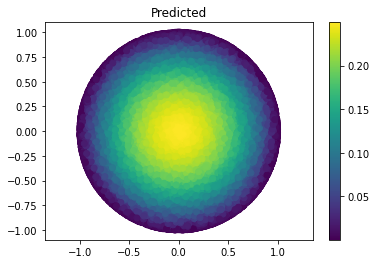

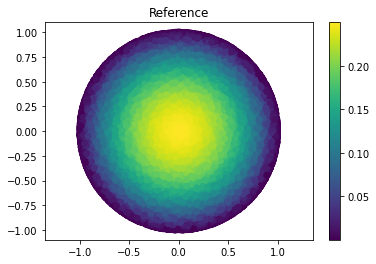

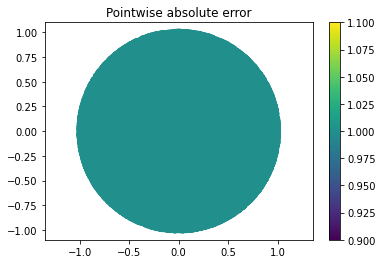

In [55]:
#Validation datapoints
num_val_dat = 100000
xy_val = generate_collocation_points(r, num_val_dat)
u_true = analytical_sol(xy_val)

xy_val = torch.tensor(xy_val, dtype=torch.float32)

u_pred = prediction(model, xy_val)

c_xy = model_c(xy_val)
c_xy = c_xy.detach().cpu().numpy()
c_xy_true = np.ones_like(c_xy)

l2_error = np.linalg.norm(u_pred - u_true)/np.linalg.norm(u_true)
l2_error_cxy = np.linalg.norm(c_xy - c_xy_true)/np.linalg.norm(c_xy_true)


print(f"Relative l2 error in u is: {l2_error*100:0.4f}%")
print(f"Relative l2 error in u is: {l2_error_cxy*100:0.4f}%")

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=u_pred)
plt.title("Predicted")
plt.axis("Equal")
plt.colorbar()
plt.show()

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=u_true)
plt.title("Reference")
plt.axis("Equal")
plt.colorbar()
plt.show()

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=c_xy_true)
plt.title("Pointwise absolute error")
plt.axis("Equal")
plt.colorbar()
plt.show()


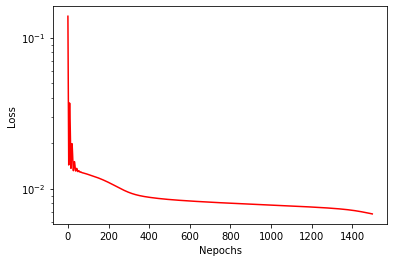

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

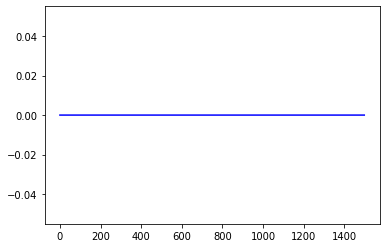

In [35]:
# Plot of convergence of loss and parameters
it = np.arange(0, nIters)
plt.semilogy(it, loss_history, "-r")
plt.xlabel("Nepochs")
plt.ylabel("Loss")
plt.show()
